In [1]:
#general libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

#torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#optuna
import optuna



In [2]:
#building a simple cnn architecture

class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout1(x)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = self.dropout2(x)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:
def get_mnist_loaders(train_batch_size, test_batch_size):

    """Get MNIST data loaders"""
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=train_batch_size, shuffle=True)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True)

    return train_loader, test_loader

In [21]:
def train_model(model, train_loader, optimizer, criterion, log_interval, epoch, device):

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))

        loss = criterion(output, target.to(device))
        loss.backward()

        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        
def validate_model(model, test_loader, criterion, device, entropy_threshold=0.5):

    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    #get the confused images
    confused_images = []


    with torch.no_grad():
        for _, (data, target) in enumerate(test_loader):
            output = model(data).to(device)
            total_loss += criterion(output, target.to(device)).item()
            
            #model prediction
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Calculate entropy
            probabilities = torch.softmax(output, dim=1)
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-8), dim=1)
            
            # Find indices of confused images
            confused_mask = entropy > entropy_threshold
            confused_images.extend(data[confused_mask].cpu().numpy())

    total_loss /= len(test_loader.dataset)
    test_accuracy = 100. * (correct / len(test_loader.dataset))
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        total_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Plot the top 9 confused images
    if confused_images:
        plot_top_confused_images(confused_images)

    return test_accuracy

def plot_top_confused_images(confused_images):
    n_confused_images = min(len(confused_images), 9)
    print(f"Plotting top {n_confused_images} confused images:")
    
    plt.figure(figsize=(10, 10))
    for i in range(n_confused_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(confused_images[i].squeeze(), cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [22]:
def train_mnist_model():

    cfg = {
        'device': "cuda" if torch.cuda.is_available() else "cpu",
        'log_interval': 100,
        'seed': 0,
        'save_model': False,
        'n_epochs': 25,
        'train_batch_size': 64,
        'test_batch_size': 128,
        'lr': 0.001,
        'momentum': 0.5,
        'criterion': nn.CrossEntropyLoss()
    }

    torch.manual_seed(cfg['seed'])
    train_loader, test_loader = get_mnist_loaders(cfg['train_batch_size'], cfg['test_batch_size'])
    model = SimpleCNN().to(cfg['device'])
    optimizer = optim.SGD(model.parameters(), lr=cfg['lr'], momentum=cfg['momentum'])
    for epoch in range(1, cfg['n_epochs']+1):
        train_model(model, train_loader, optimizer, cfg['criterion'], cfg['log_interval'], epoch, cfg['device'])
        test_accuracy = validate_model(model, test_loader, cfg['criterion'], cfg['device'])

    if cfg['save_model']:
        torch.save(model.state_dict(), "mnist_cnn.pt")

    return test_accuracy


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.265291
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.248286
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.206010
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.124312
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.991265
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.814601
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.501152
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.096366
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.098063

Test set: Average loss: 0.0058, Accuracy: 8254/10000 (83%)

Plotting top 9 confused images:


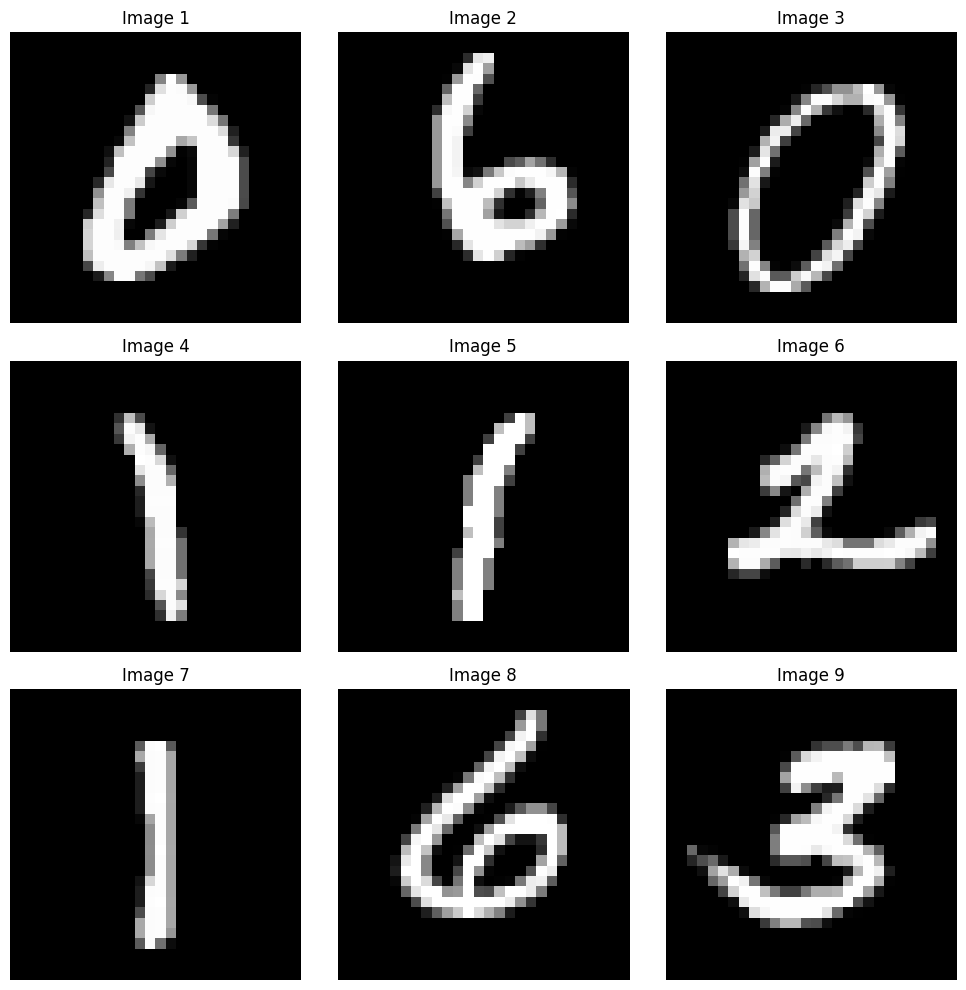

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.791078
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.712618
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.564702
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.588403
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.570411


KeyboardInterrupt: 

In [91]:
if __name__ == "__main__":
    train_mnist_model()

## Optimise the hyper-parameters using Optuna

In [23]:
def objective(trial):

    cfg = {
        'device': "cuda" if torch.cuda.is_available() else "cpu",
        'log_interval': 100,
        'seed': 0,
        'save_model': False,
        'n_epochs': 5,
        'train_batch_size': 64,
        'test_batch_size': 512,
        'lr': trial.suggest_float("lr", 1e-5, 1e-2, log=True),
        'momentum': trial.suggest_float("momentum", 0.4, 0.9, step=0.1),
        'criterion': nn.CrossEntropyLoss()
    }

    torch.manual_seed(cfg['seed'])
    train_loader, test_loader = get_mnist_loaders(cfg['train_batch_size'], cfg['test_batch_size'])
    model = SimpleCNN().to(cfg['device'])
    optimizer = optim.SGD(model.parameters(), lr=cfg['lr'], momentum=cfg['momentum'])
    for epoch in range(1, cfg['n_epochs']+1):
        train_model(model, train_loader, optimizer, cfg['criterion'], cfg['log_interval'], epoch, cfg['device'])
        test_accuracy = validate_model(model, test_loader, cfg['criterion'], cfg['device'])

    if cfg['save_model']:
        torch.save(model.state_dict(), "mnist_cnn.pt")

    return test_accuracy


__Creting the study with optuna__

[I 2024-03-16 11:27:32,281] A new study created in RDB with name: mnist_classification


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.258554
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.229698
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.154867
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.000893
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.690629
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.318795
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.991164
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.678909
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.887693

Test set: Average loss: 0.0011, Accuracy: 8588/10000 (86%)

Plotting top 9 confused images:


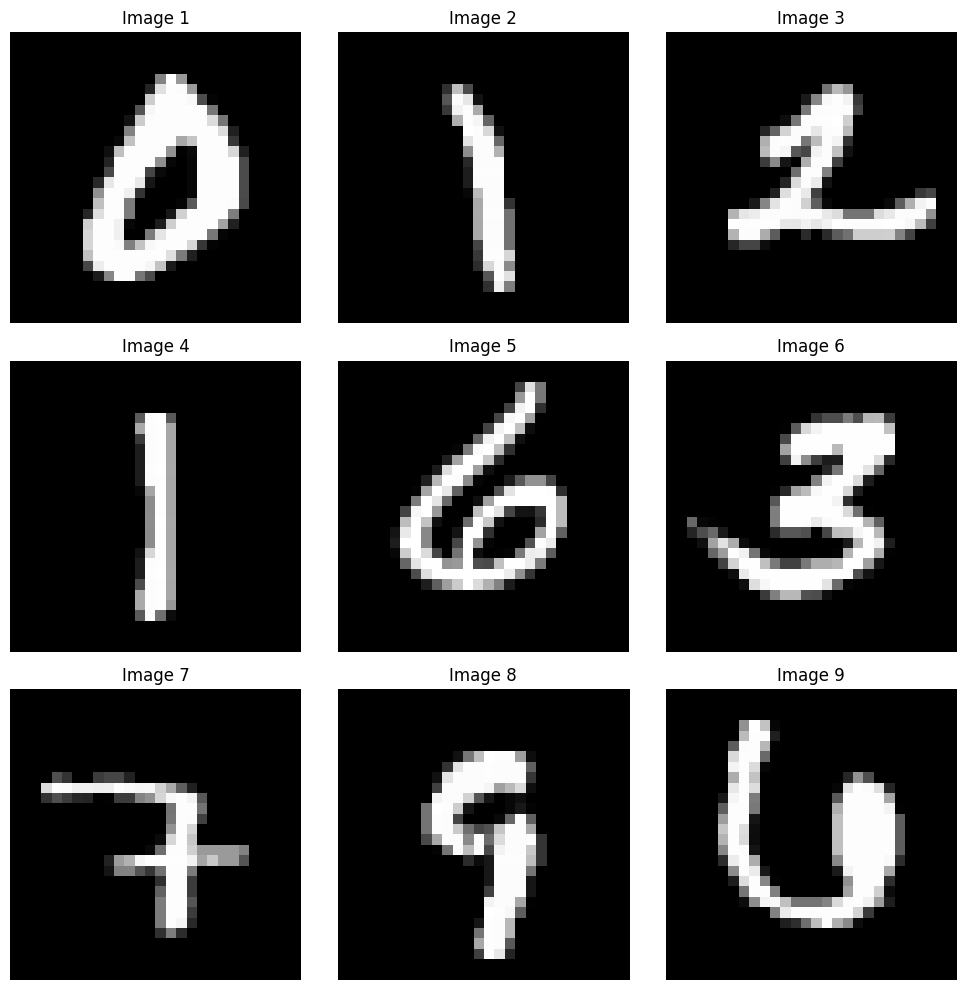

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.550617
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.498974
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.417564
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.484531
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.481182
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.508121
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.572420
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.369766
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.281137
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.257763

Test set: Average loss: 0.0006, Accuracy: 9036/10000 (90%)

Plotting top 9 confused images:


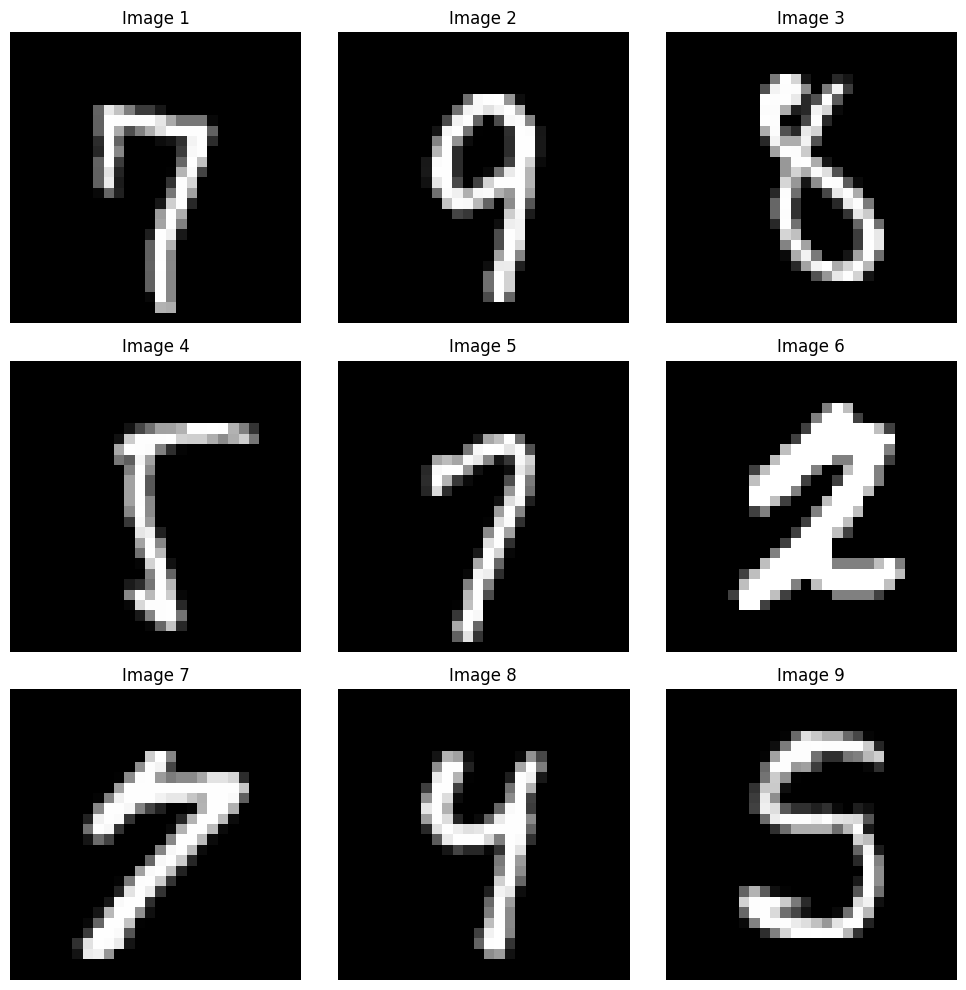

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.467502
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.278090
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.402267
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.422164
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.479222
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.324039
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.381074
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.179788
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.259228
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.626565

Test set: Average loss: 0.0005, Accuracy: 9248/10000 (92%)

Plotting top 9 confused images:


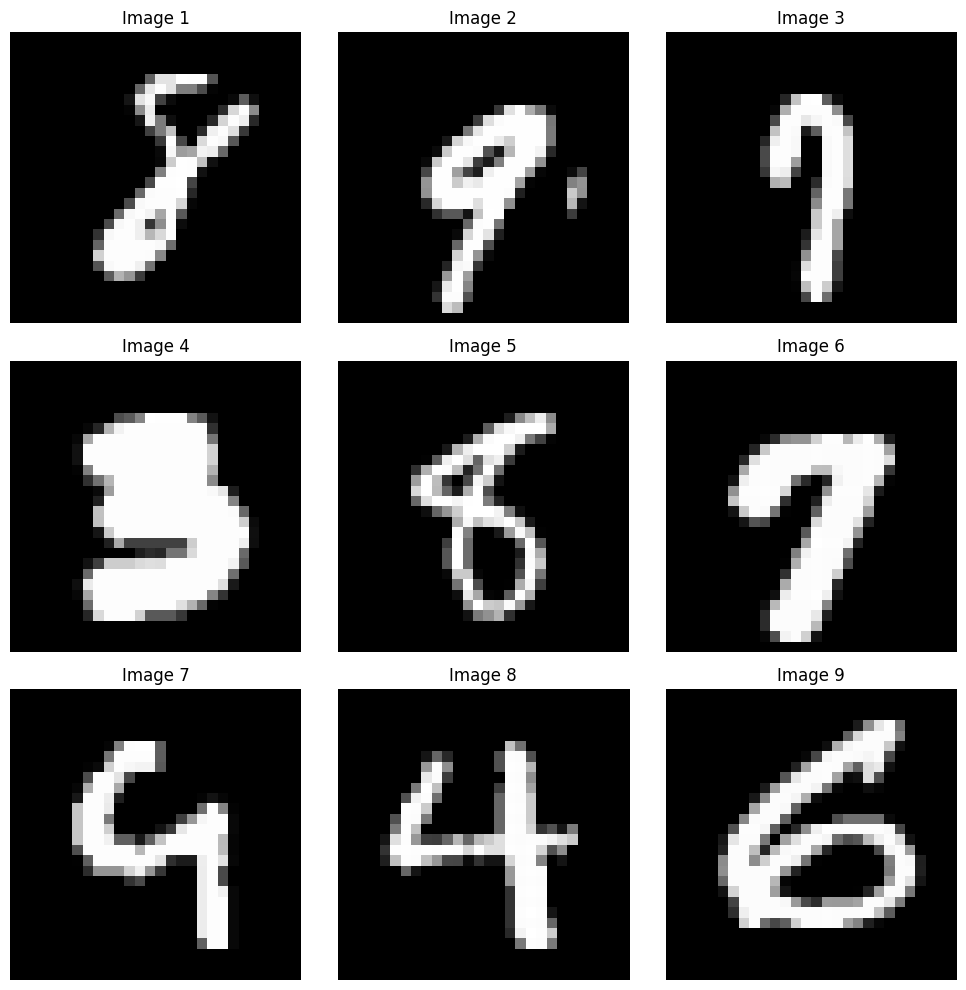

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.266907
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.341046
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.667287
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.258174
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.368197
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.678446
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.262561
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.169857
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.287143
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.240821

Test set: Average loss: 0.0004, Accuracy: 9365/10000 (94%)

Plotting top 9 confused images:


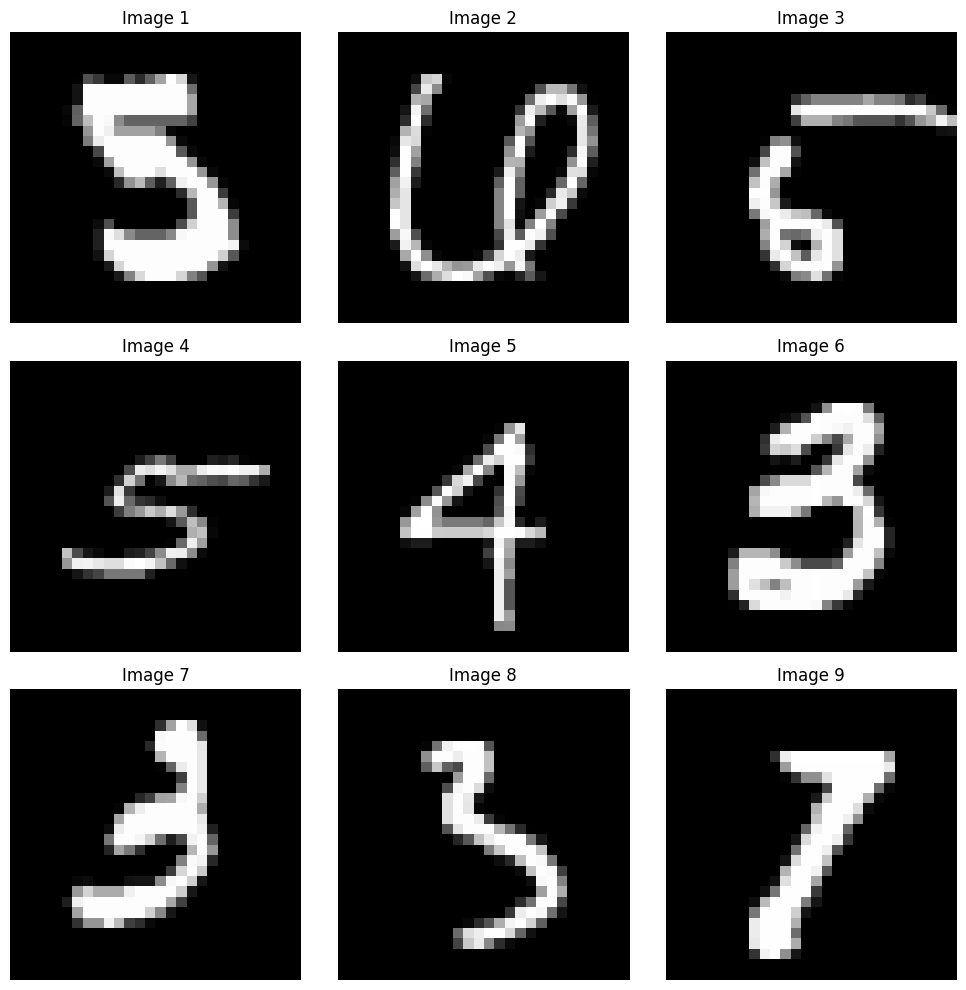

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.222088
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.226310
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.212865
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.276791
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.333610
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.332800
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.331442
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.198464
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.195629
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.385329

Test set: Average loss: 0.0004, Accuracy: 9448/10000 (94%)

Plotting top 9 confused images:


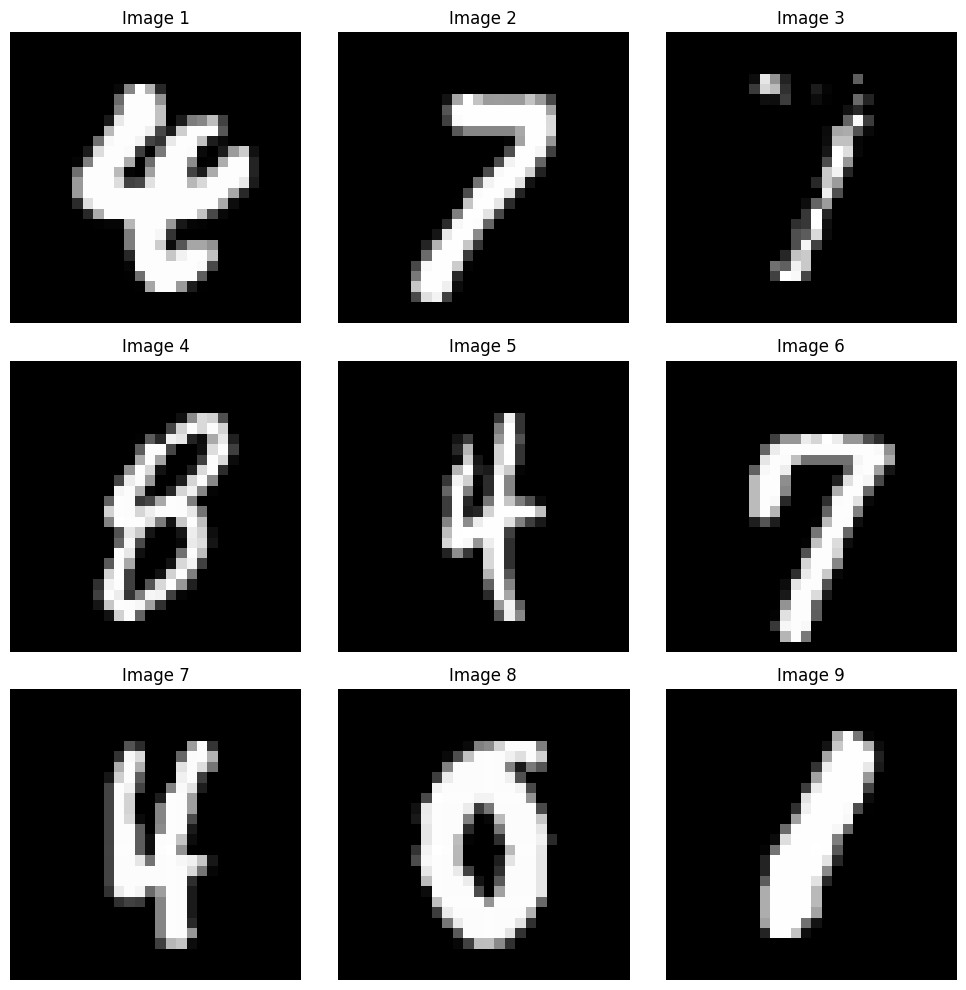

[I 2024-03-16 11:28:57,786] Trial 0 finished with value: 94.48 and parameters: {'lr': 0.001005776458507178, 'momentum': 0.6000000000000001}. Best is trial 0 with value: 94.48.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.281397
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.284899
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.280489
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.259496
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.258118
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.260855
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.236798
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.220691
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.218601

Test set: Average loss: 0.0044, Accuracy: 6059/10000 (61%)

Plotting top 9 confused images:


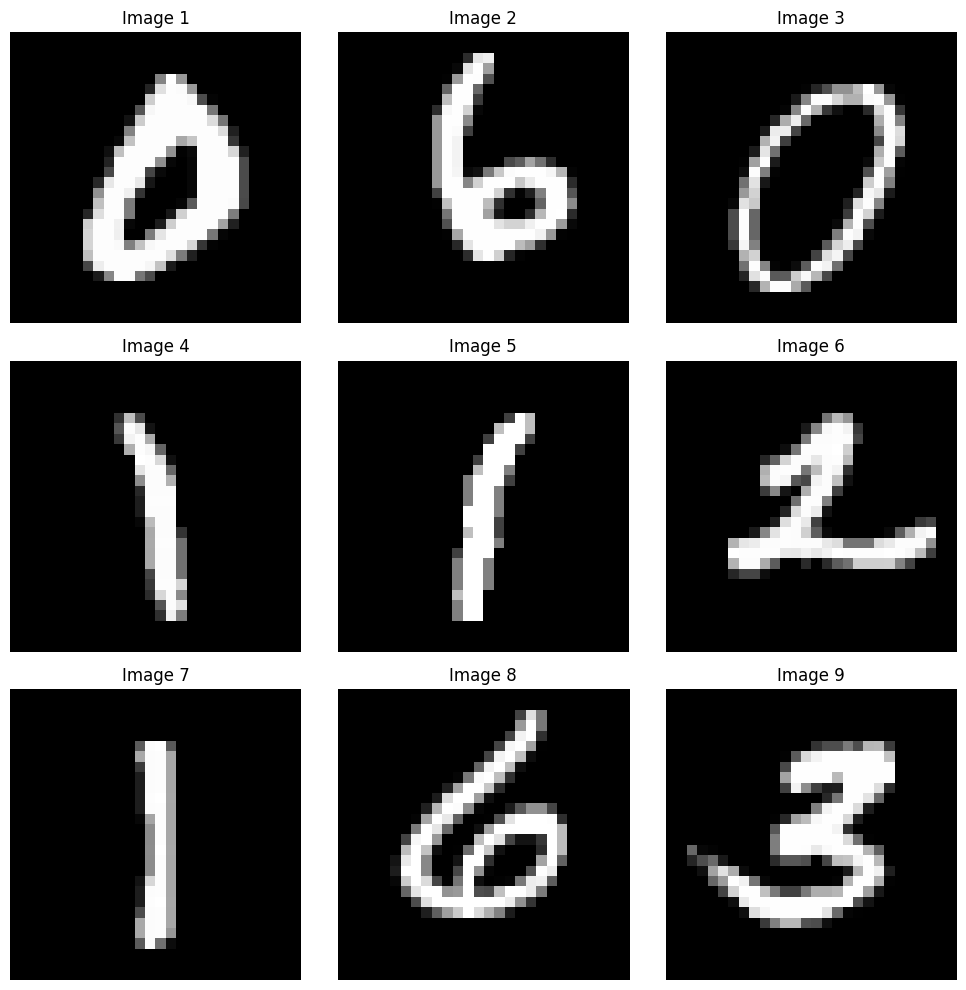

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.196691
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.196628
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.152711
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.166275
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.100797
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.067793
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.047076
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.988404
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.910085
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.826184

Test set: Average loss: 0.0036, Accuracy: 7355/10000 (74%)

Plotting top 9 confused images:


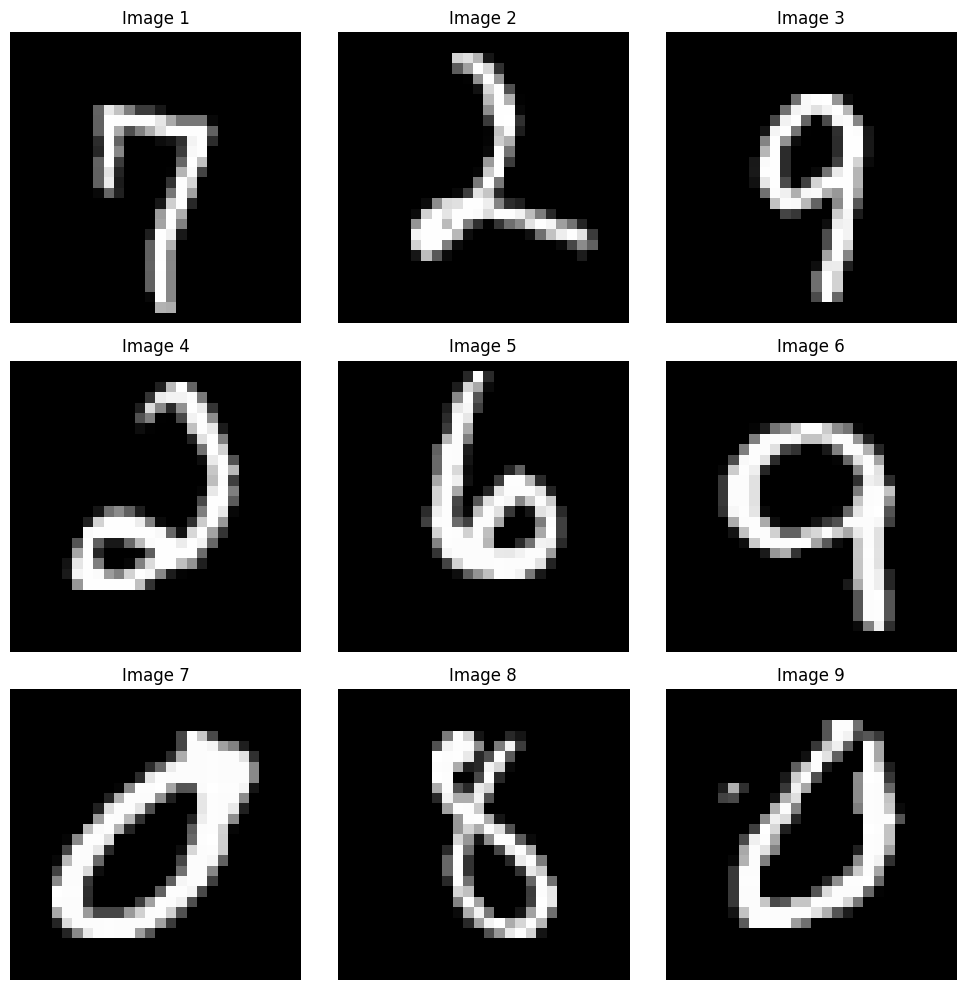

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.903170
Train Epoch: 3 [6400/60000 (11%)]	Loss: 1.703704
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.709846
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.551128
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.493520
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.370113
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.415970
Train Epoch: 3 [44800/60000 (75%)]	Loss: 1.054960
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.034114
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.053316

Test set: Average loss: 0.0017, Accuracy: 8132/10000 (81%)

Plotting top 9 confused images:


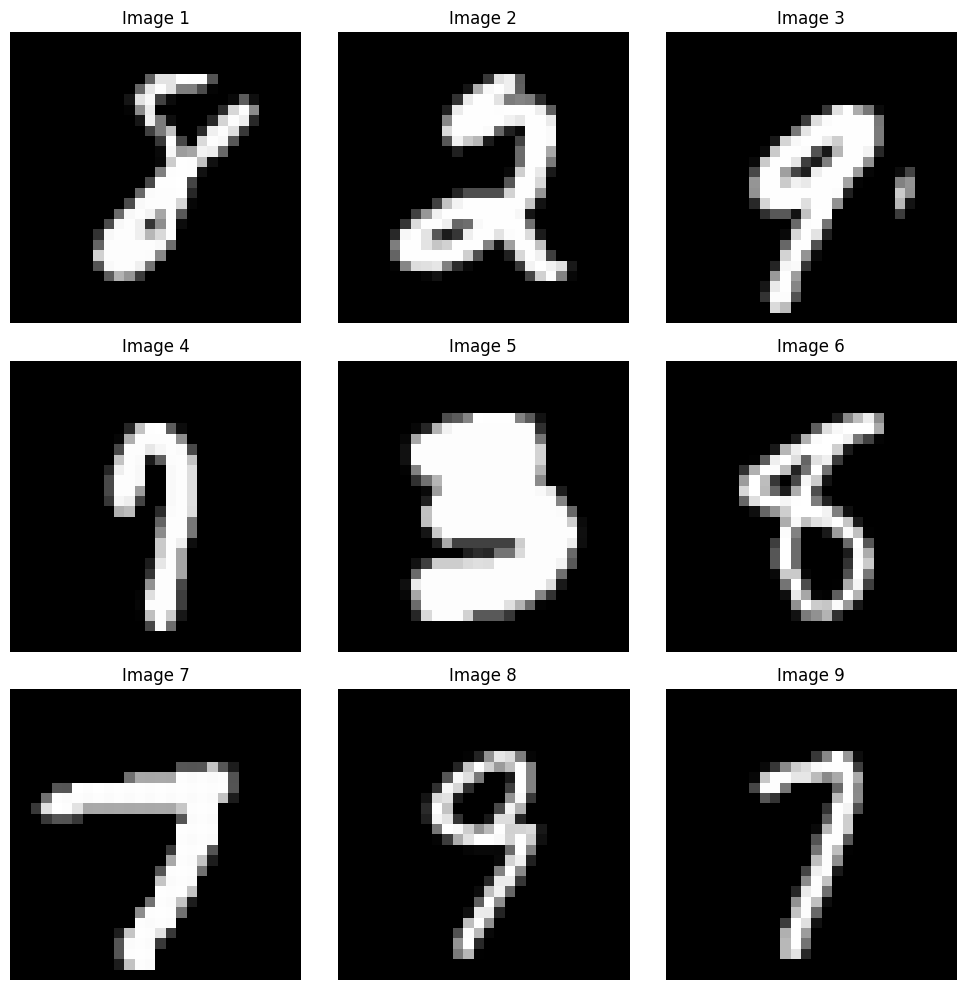

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.025276
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.897200
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.965130
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.807498
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.818486
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.971240
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.634611
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.536372
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.559529
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.635259

Test set: Average loss: 0.0011, Accuracy: 8583/10000 (86%)

Plotting top 9 confused images:


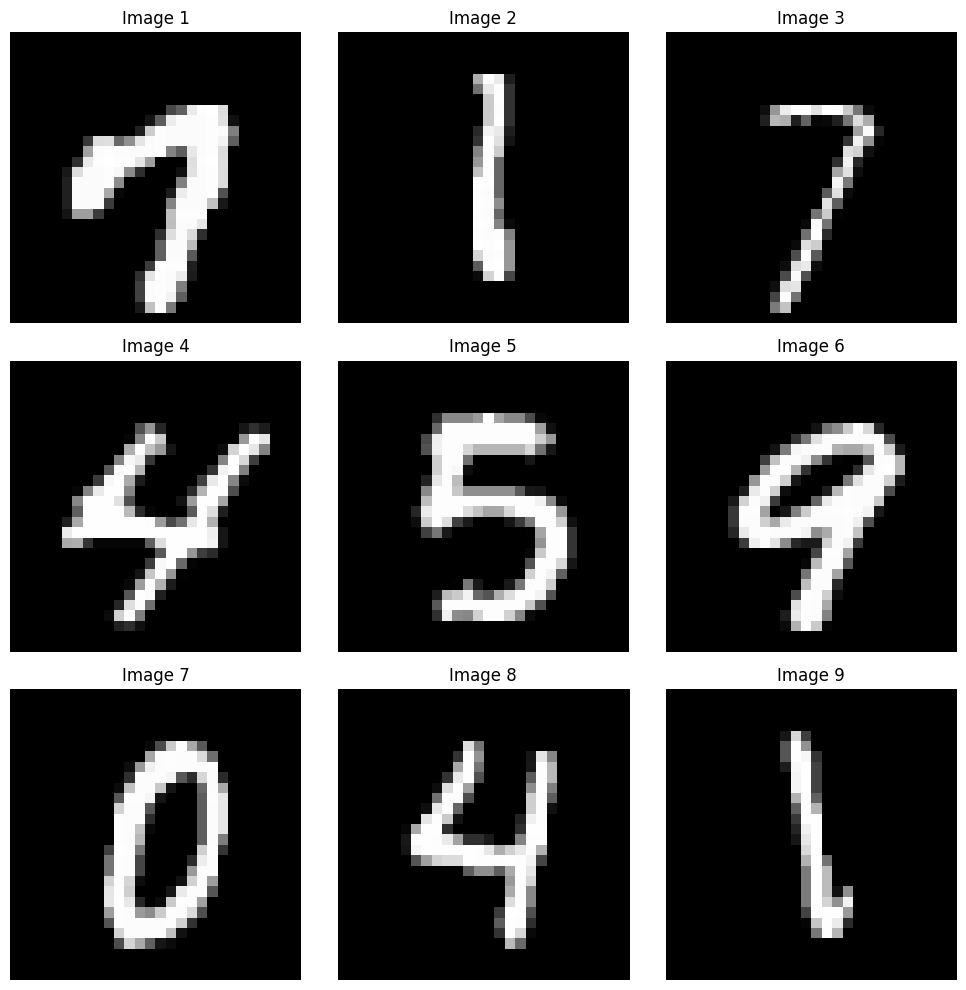

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.596197
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.507723
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.660114
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.600830
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.649394
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.634827
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.581275
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.482136
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.575271
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.545303

Test set: Average loss: 0.0009, Accuracy: 8837/10000 (88%)

Plotting top 9 confused images:


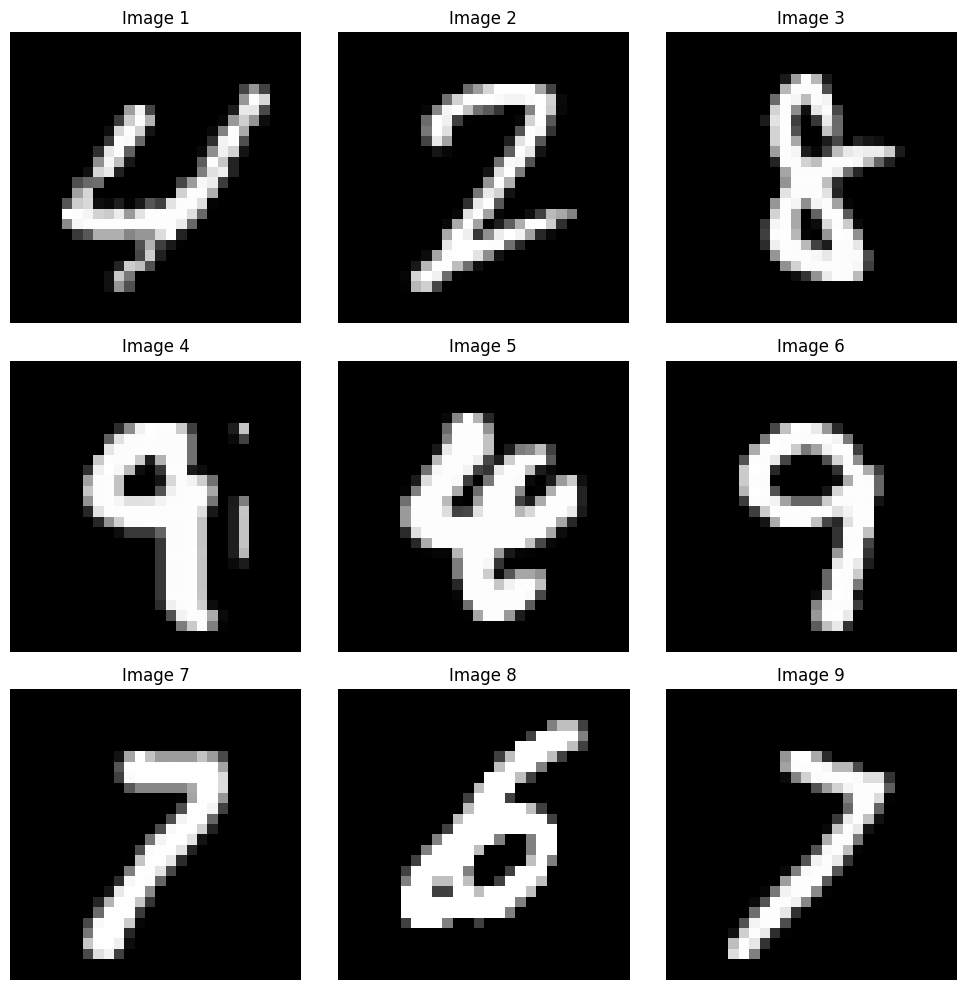

[I 2024-03-16 11:30:23,206] Trial 1 finished with value: 88.37 and parameters: {'lr': 0.0002455158980786338, 'momentum': 0.6000000000000001}. Best is trial 0 with value: 94.48.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.287098
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.296895
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.298697
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.282873
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.292800
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.302227
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.288876
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.289594
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.290161

Test set: Average loss: 0.0046, Accuracy: 1844/10000 (18%)

Plotting top 9 confused images:


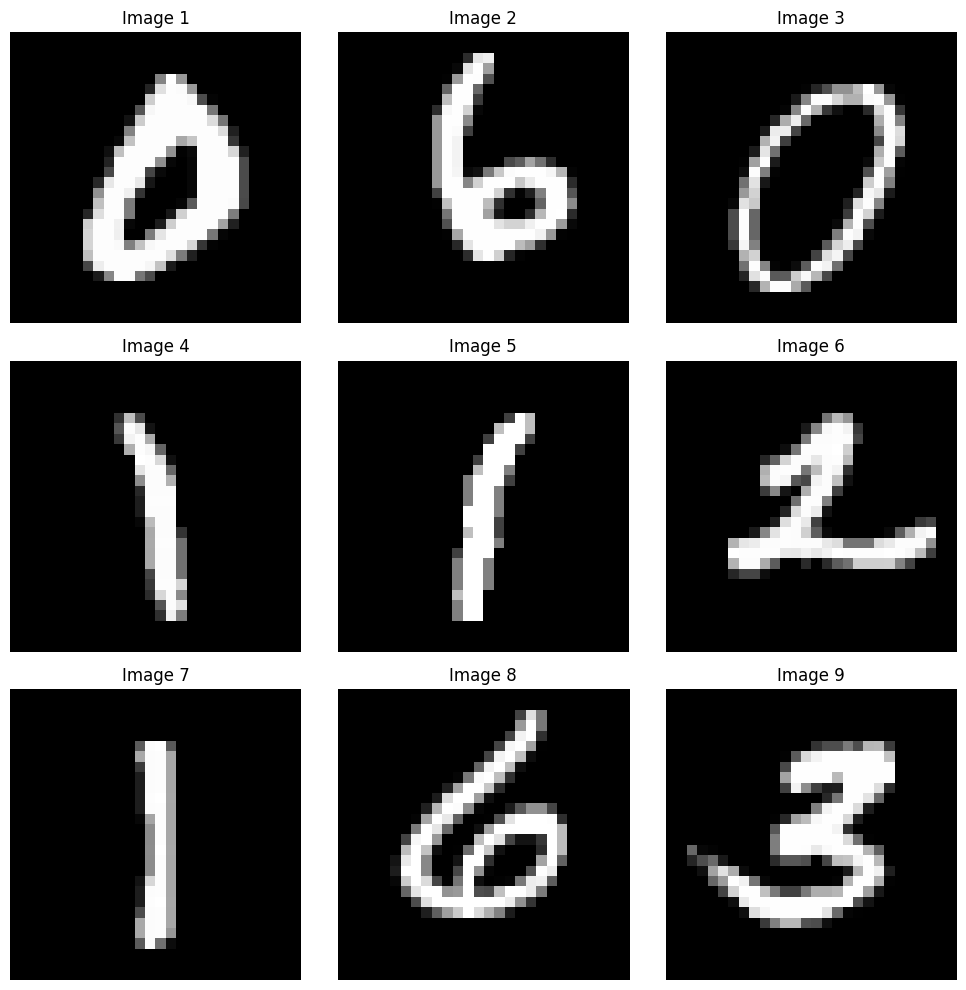

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.278317
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.289092
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.280456
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.302991
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.274827
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.283329
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.287350
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.287713
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.268099
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.286226

Test set: Average loss: 0.0046, Accuracy: 2342/10000 (23%)

Plotting top 9 confused images:


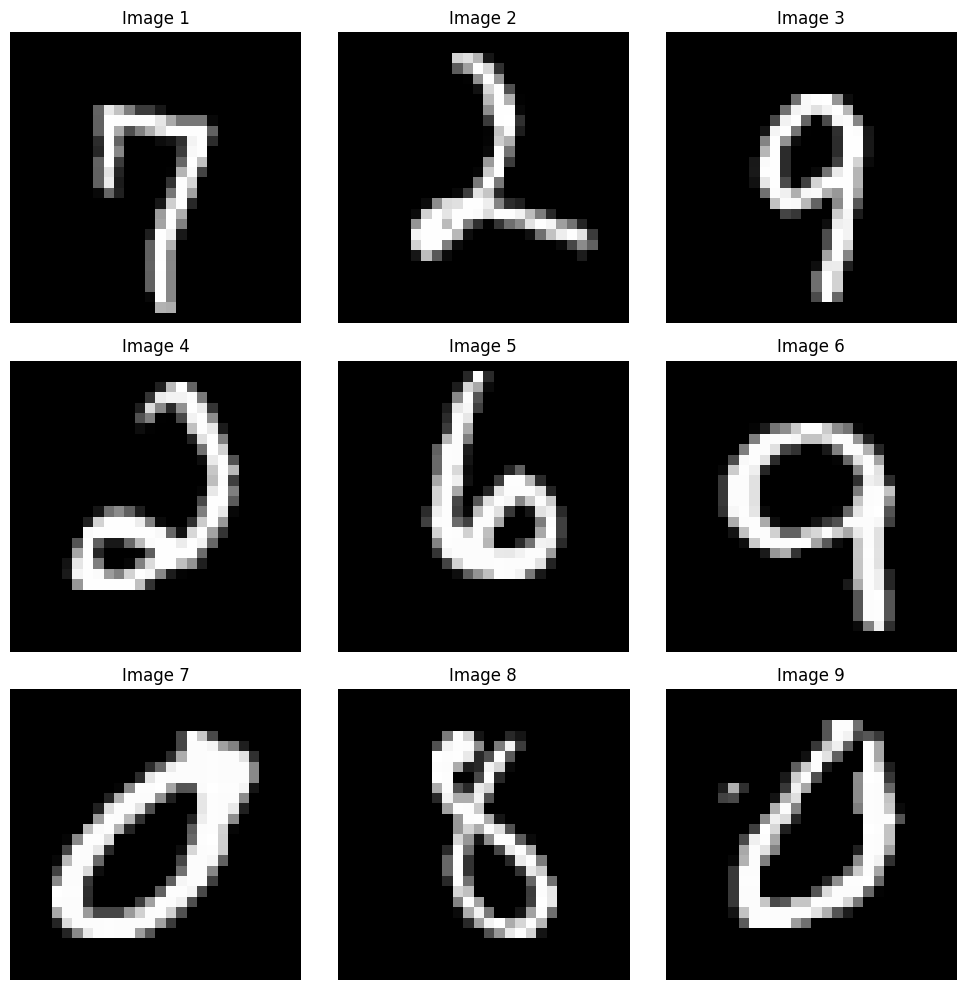

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.294948
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.292277
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.310823
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.270333
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.278207
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.287171
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.279868
Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.273268
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.263690
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.269104

Test set: Average loss: 0.0045, Accuracy: 3087/10000 (31%)

Plotting top 9 confused images:


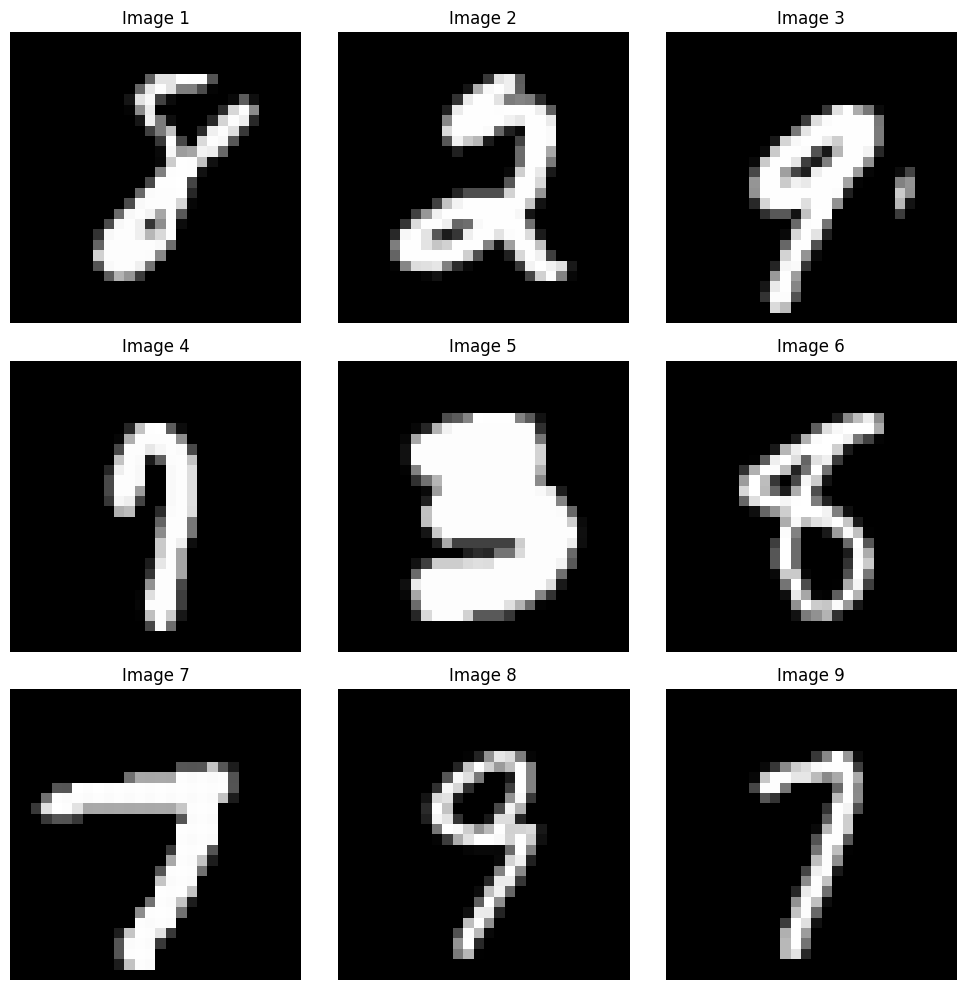

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.300955
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.286120
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.285629
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.264722
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.257967
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.260634
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.274184
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.266458
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.279988
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.272356

Test set: Average loss: 0.0045, Accuracy: 3924/10000 (39%)

Plotting top 9 confused images:


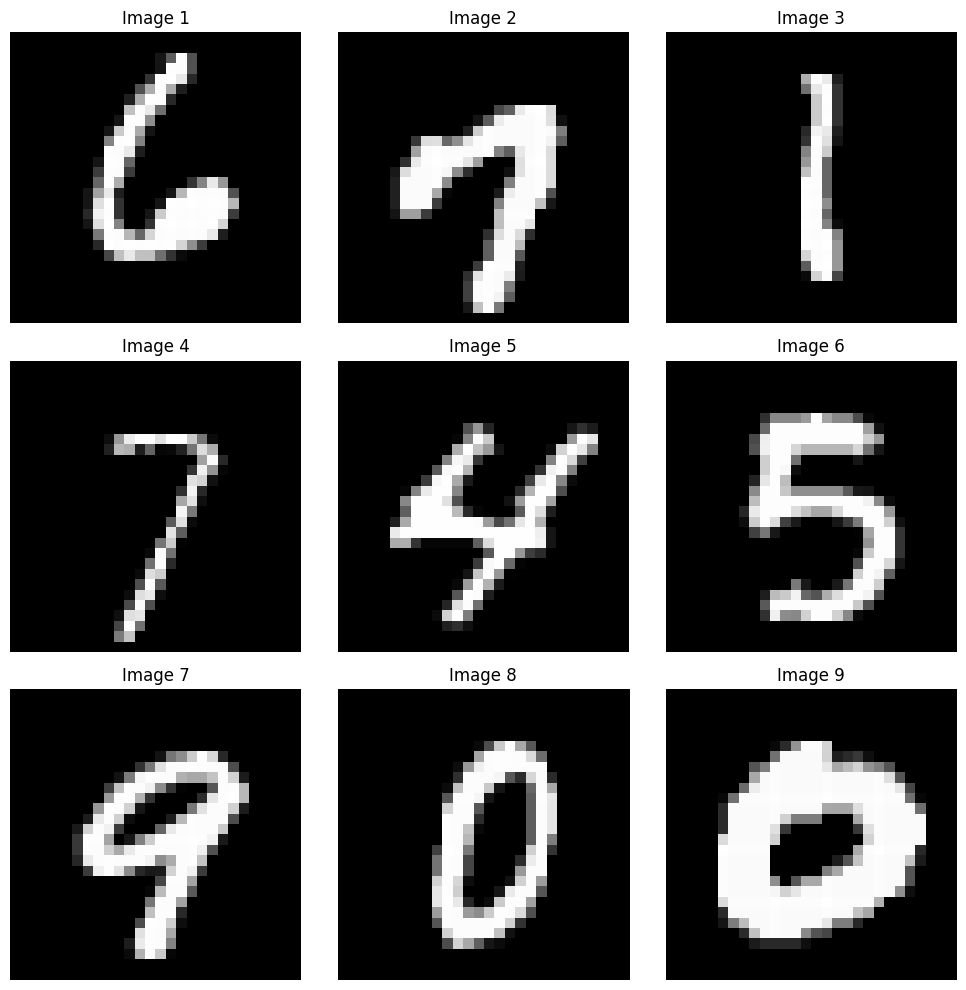

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.275143
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.249908
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.270352
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.252759
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.283672
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.282526
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.247211
Train Epoch: 5 [44800/60000 (75%)]	Loss: 2.261316
Train Epoch: 5 [51200/60000 (85%)]	Loss: 2.263563
Train Epoch: 5 [57600/60000 (96%)]	Loss: 2.258158

Test set: Average loss: 0.0045, Accuracy: 4578/10000 (46%)

Plotting top 9 confused images:


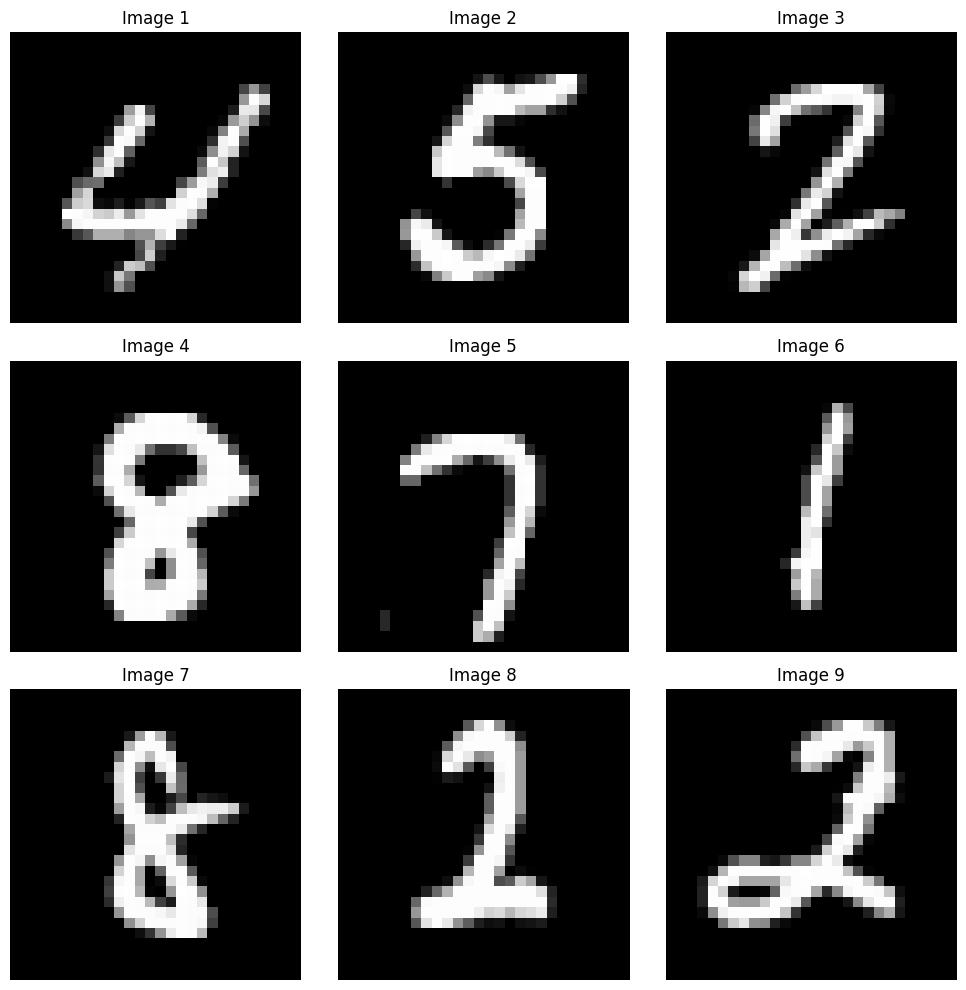

[I 2024-03-16 11:31:49,271] Trial 2 finished with value: 45.78 and parameters: {'lr': 1.9215585438865248e-05, 'momentum': 0.7000000000000001}. Best is trial 0 with value: 94.48.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.287242
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.297209
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.299145
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.283388
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.293600
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.303190
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.289917
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.290735
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.291568

Test set: Average loss: 0.0046, Accuracy: 1761/10000 (18%)

Plotting top 9 confused images:


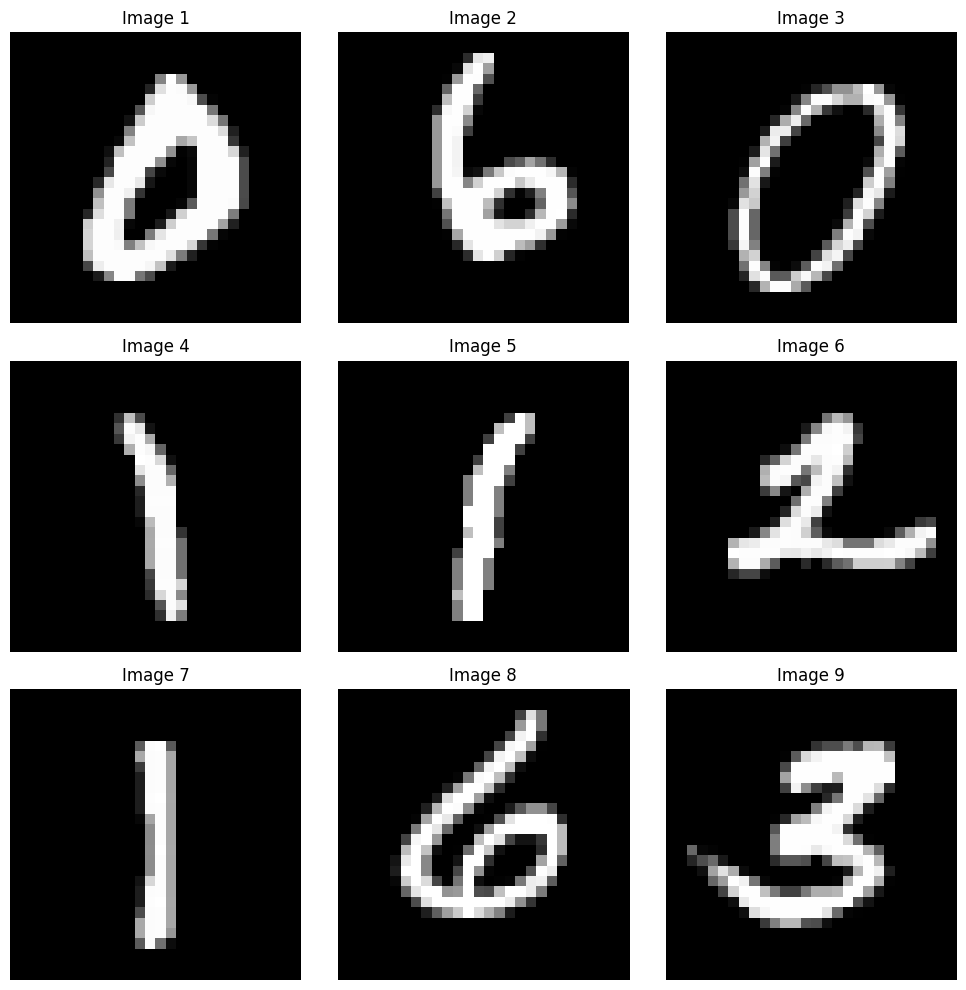

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.279594
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.290421
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.282180
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.305194
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.276977
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.285872
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.289967
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.290334
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.270909
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.289824

Test set: Average loss: 0.0046, Accuracy: 2104/10000 (21%)

Plotting top 9 confused images:


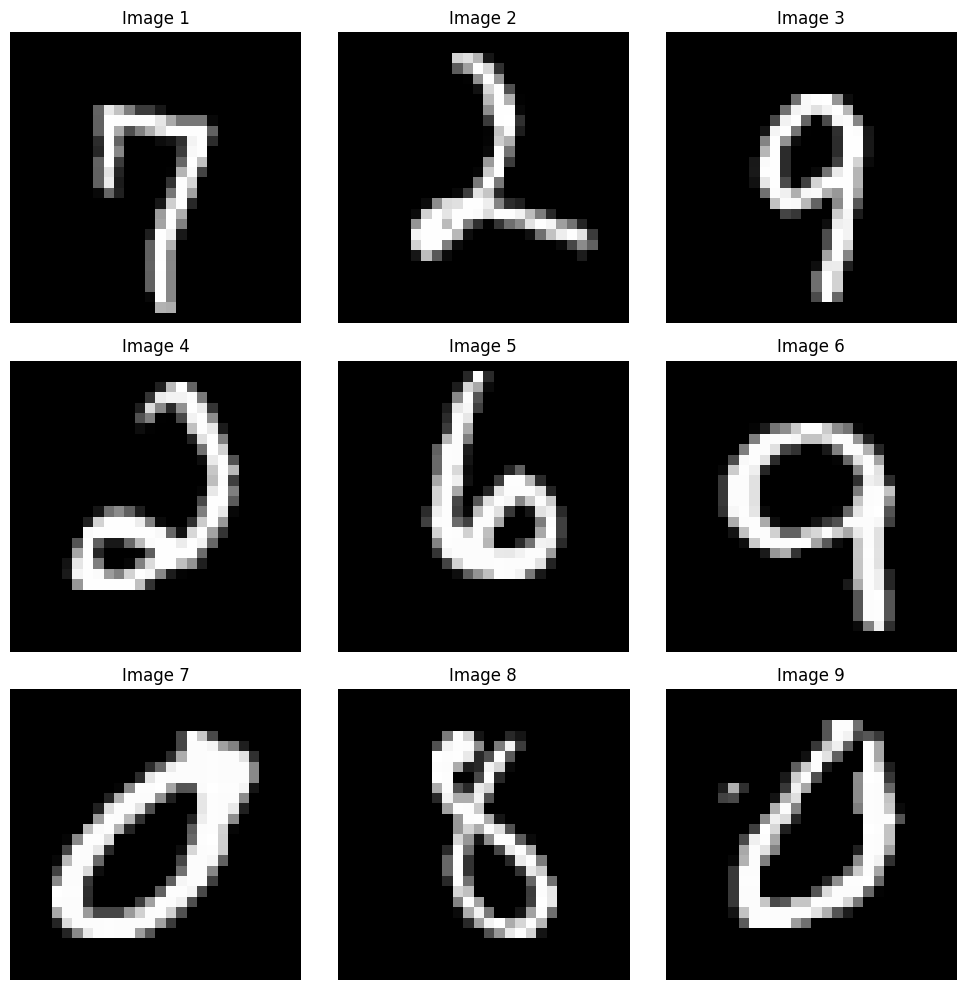

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.297779
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.296323
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.314345
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.273799
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.281927
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.291254
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.282784
Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.278107
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.268692
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.274086

Test set: Average loss: 0.0046, Accuracy: 2568/10000 (26%)

Plotting top 9 confused images:


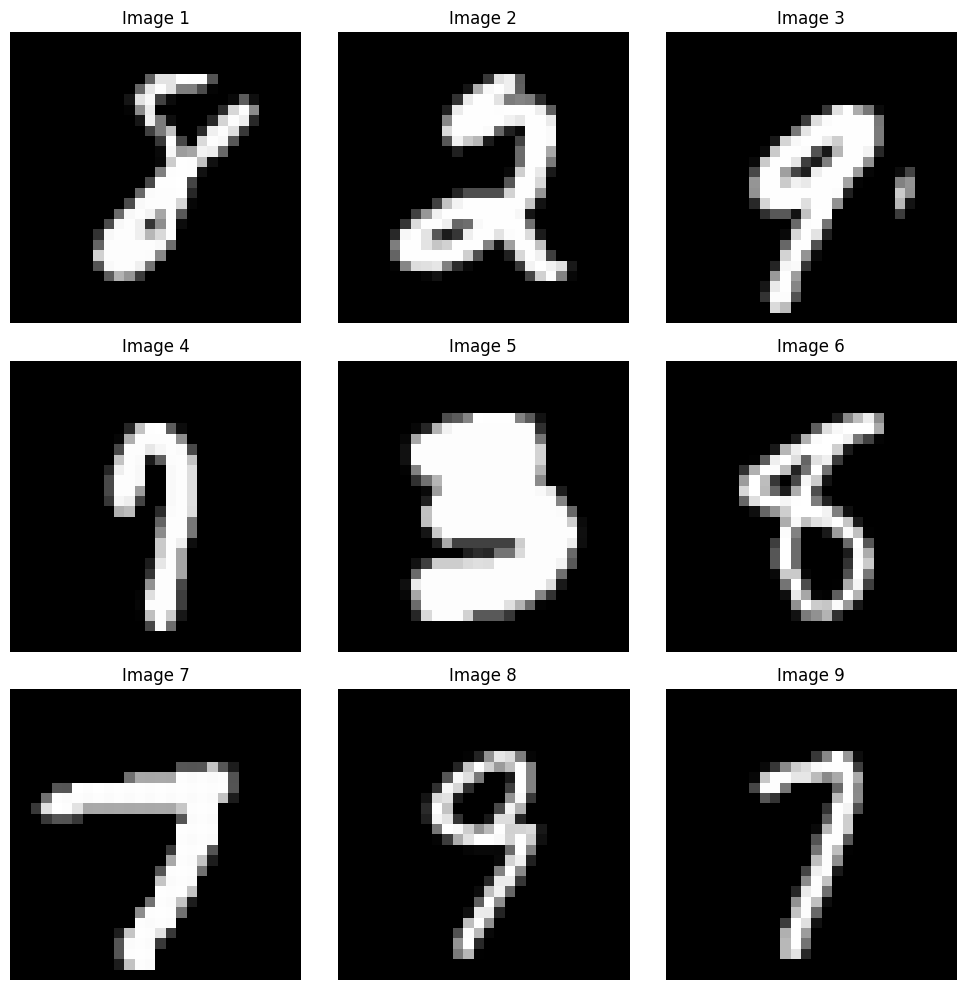

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.305787
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.292284
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.290859
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.270414
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.263533
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.266204
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.280717
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.273222
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.287749
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.279161

Test set: Average loss: 0.0045, Accuracy: 3167/10000 (32%)

Plotting top 9 confused images:


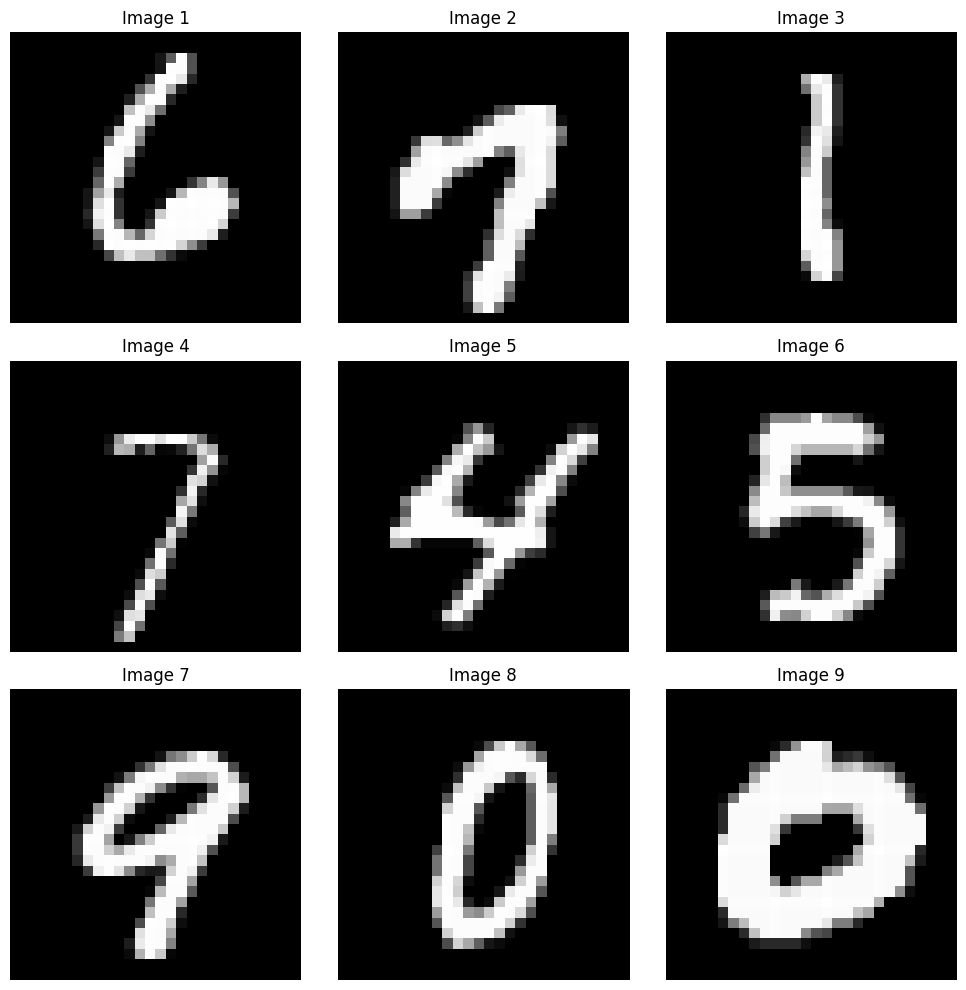

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.282984
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.258001
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.277163
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.260999
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.292044
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.290851
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.256405
Train Epoch: 5 [44800/60000 (75%)]	Loss: 2.271521
Train Epoch: 5 [51200/60000 (85%)]	Loss: 2.271834
Train Epoch: 5 [57600/60000 (96%)]	Loss: 2.267543

Test set: Average loss: 0.0045, Accuracy: 3805/10000 (38%)

Plotting top 9 confused images:


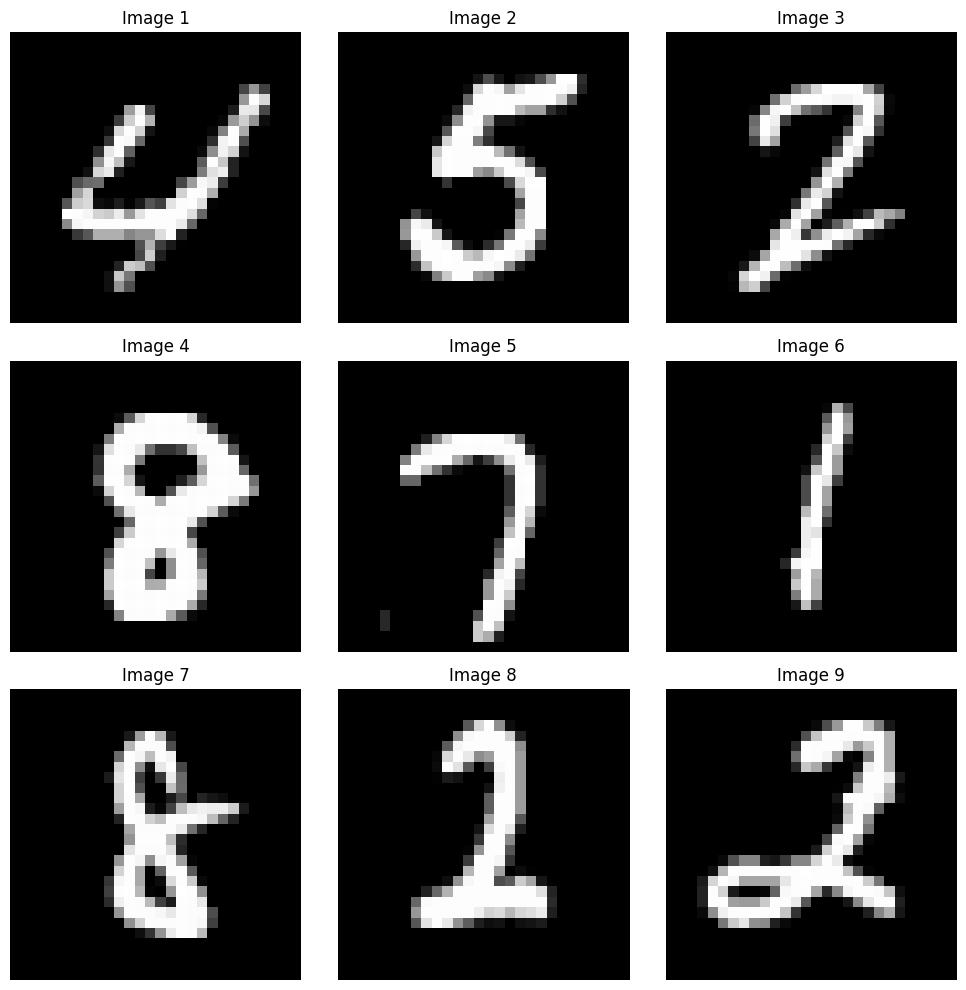

[I 2024-03-16 11:33:14,862] Trial 3 finished with value: 38.05 and parameters: {'lr': 1.9675387906524448e-05, 'momentum': 0.6000000000000001}. Best is trial 0 with value: 94.48.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.284867
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.292139
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.291760
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.274558
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.280535
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.287360
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.271886
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.269021
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.266777

Test set: Average loss: 0.0045, Accuracy: 4273/10000 (43%)

Plotting top 9 confused images:


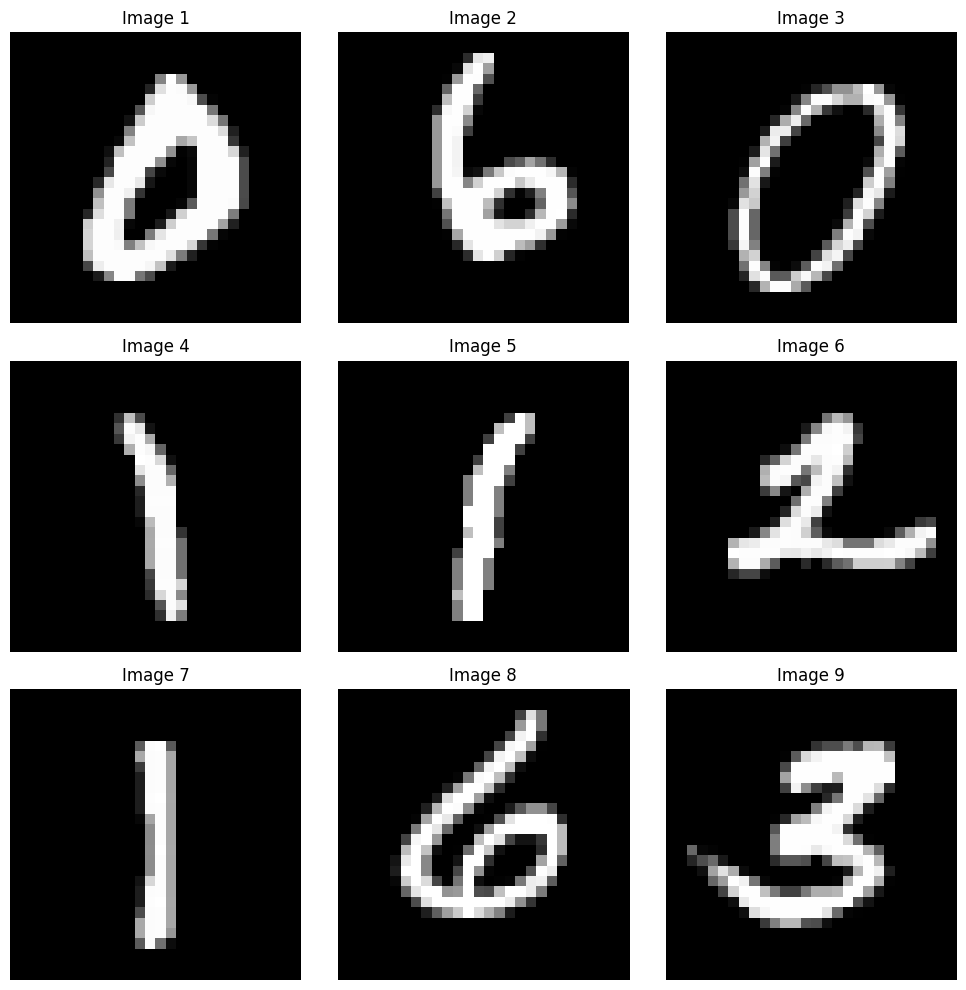

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.255470
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.264427
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.247986
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.267290
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.235071
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.236231
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.239815
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.234581
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.208630
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.216480

Test set: Average loss: 0.0044, Accuracy: 5965/10000 (60%)

Plotting top 9 confused images:


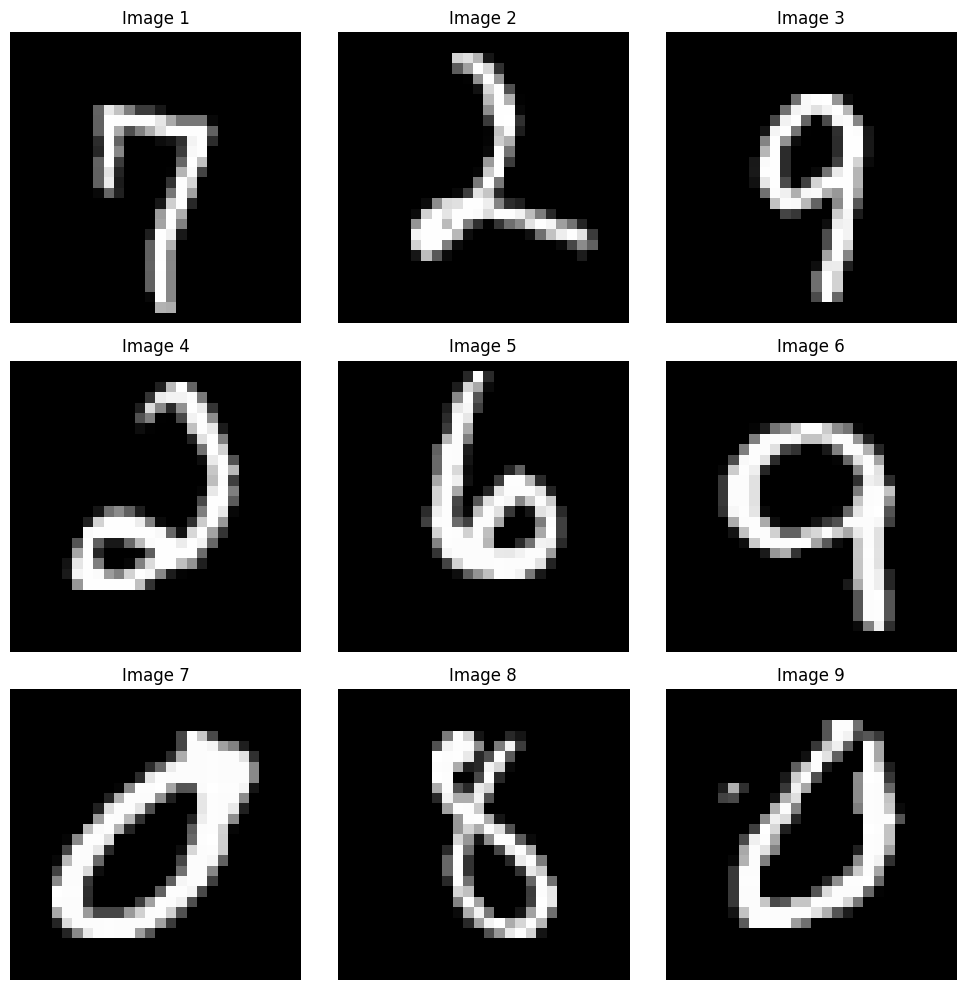

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.233765
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.207775
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.229320
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.185281
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.185745
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.183688
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.191162
Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.145449
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.123641
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.119165

Test set: Average loss: 0.0042, Accuracy: 6700/10000 (67%)

Plotting top 9 confused images:


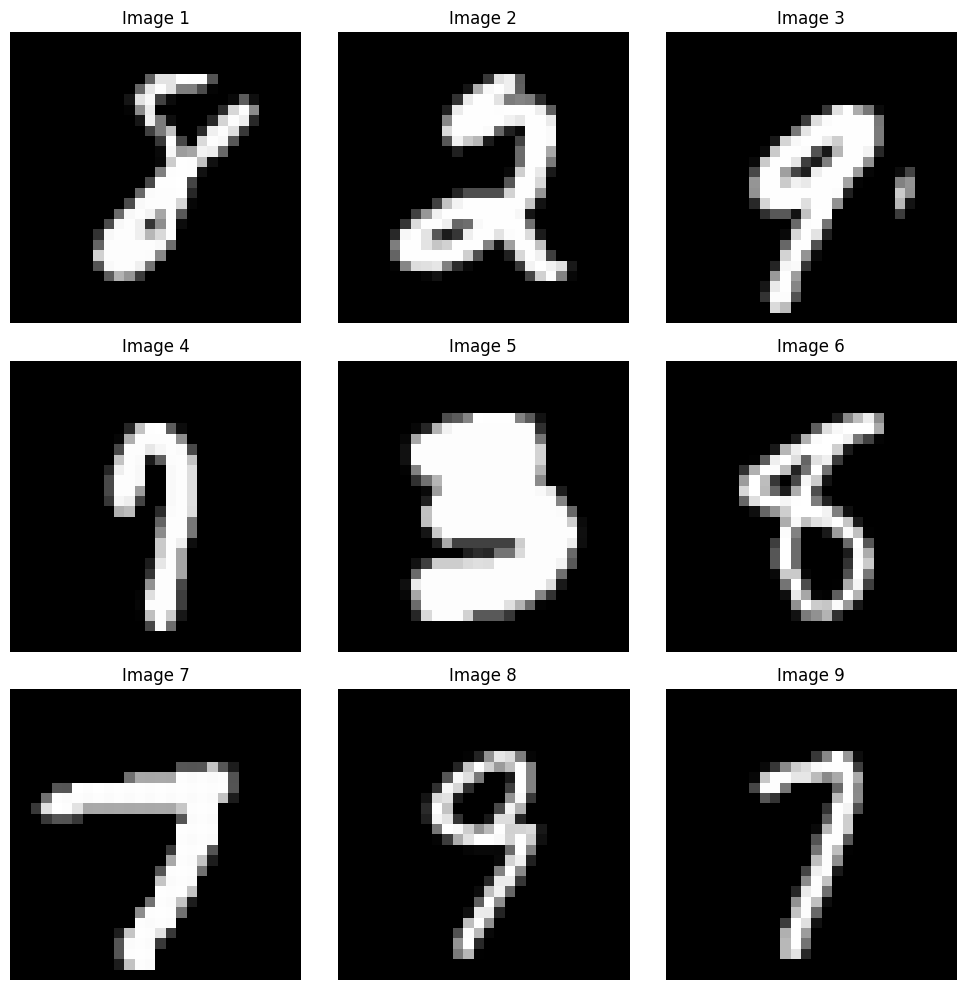

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.163785
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.107388
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.117606
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.063373
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.037583
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.054935
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.019123
Train Epoch: 4 [44800/60000 (75%)]	Loss: 1.967251
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.961976
Train Epoch: 4 [57600/60000 (96%)]	Loss: 1.951820

Test set: Average loss: 0.0038, Accuracy: 7192/10000 (72%)

Plotting top 9 confused images:


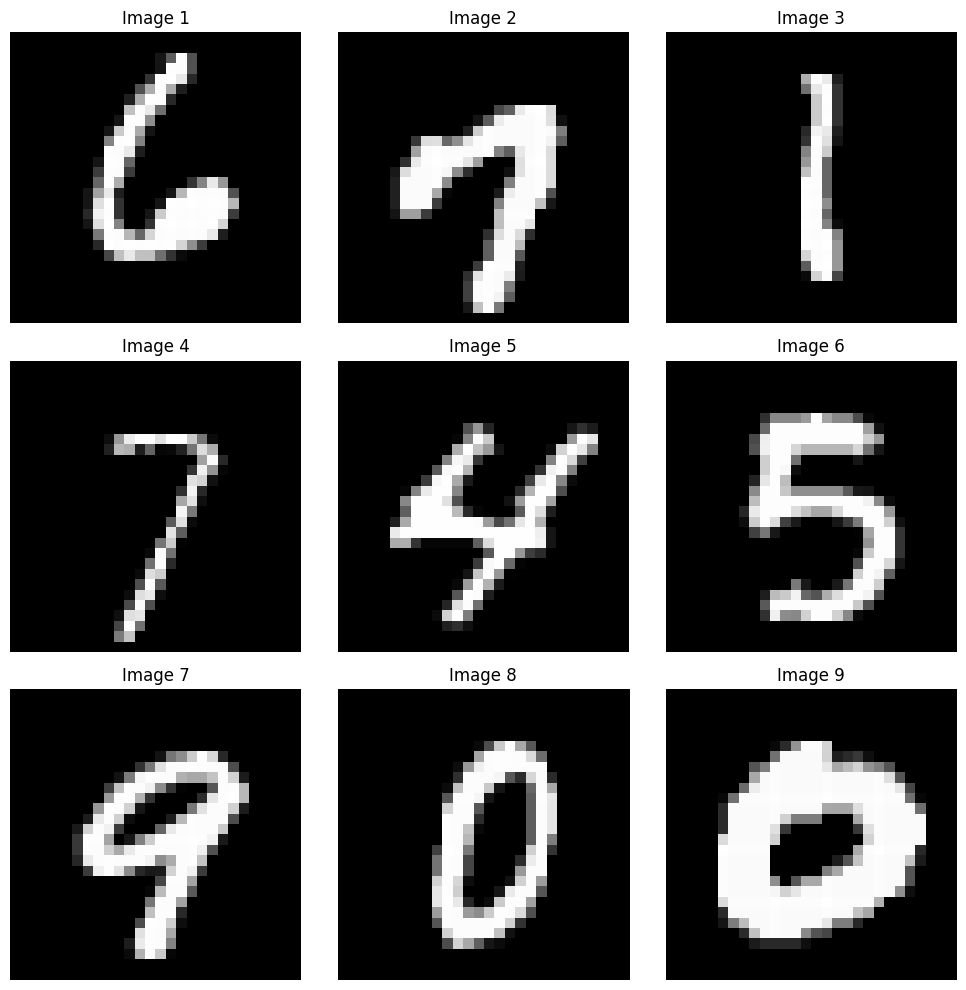

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.938835
Train Epoch: 5 [6400/60000 (11%)]	Loss: 1.843369
Train Epoch: 5 [12800/60000 (21%)]	Loss: 1.928367
Train Epoch: 5 [19200/60000 (32%)]	Loss: 1.817738
Train Epoch: 5 [25600/60000 (43%)]	Loss: 1.854221
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.812772
Train Epoch: 5 [38400/60000 (64%)]	Loss: 1.705711
Train Epoch: 5 [44800/60000 (75%)]	Loss: 1.619984
Train Epoch: 5 [51200/60000 (85%)]	Loss: 1.674302
Train Epoch: 5 [57600/60000 (96%)]	Loss: 1.542010

Test set: Average loss: 0.0030, Accuracy: 7703/10000 (77%)

Plotting top 9 confused images:


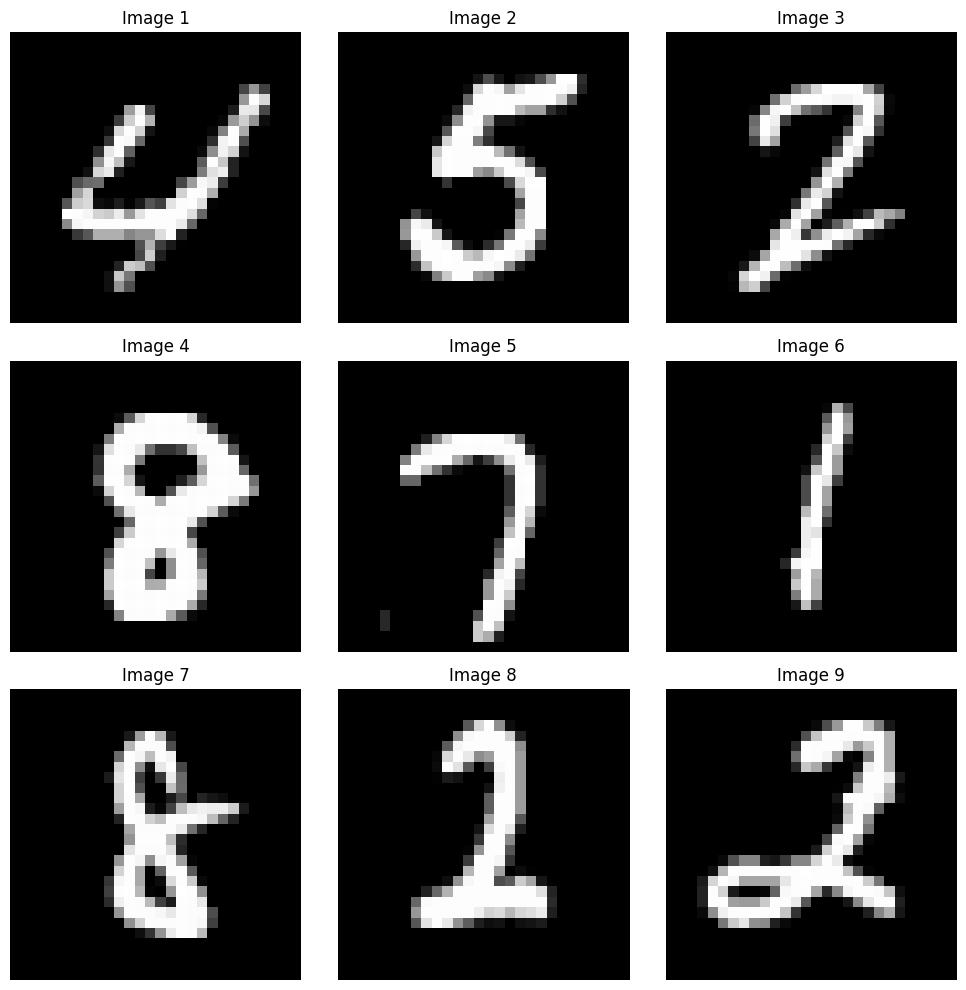

[I 2024-03-16 11:34:41,673] Trial 4 finished with value: 77.03 and parameters: {'lr': 8.523909700852051e-05, 'momentum': 0.7000000000000001}. Best is trial 0 with value: 94.48.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.438979
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.420708
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.122470
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.302081
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.099313
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.192173
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.168917
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.183169
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.312767

Test set: Average loss: 0.0002, Accuracy: 9747/10000 (97%)

Plotting top 9 confused images:


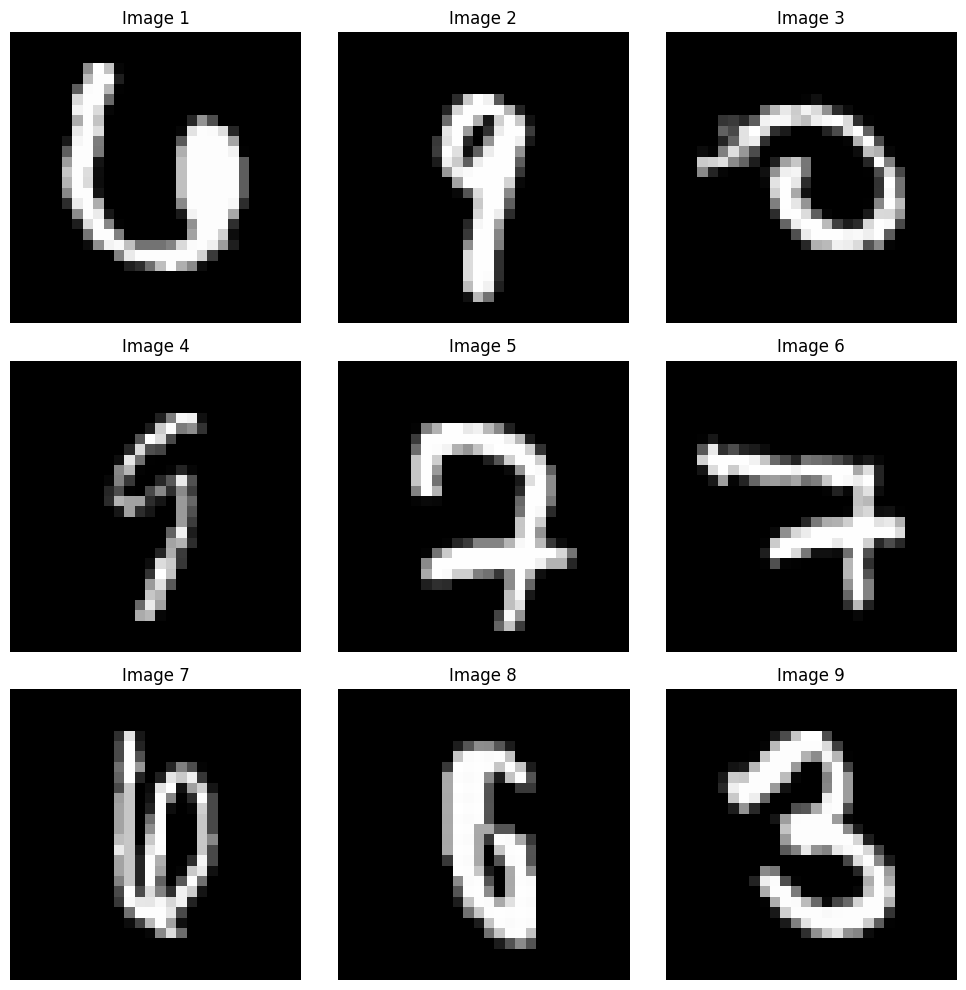

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.105966
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.099336
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.085536
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.224775
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.058182
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.139045
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.028586
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.019658
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.024478
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.064432

Test set: Average loss: 0.0001, Accuracy: 9839/10000 (98%)

Plotting top 9 confused images:


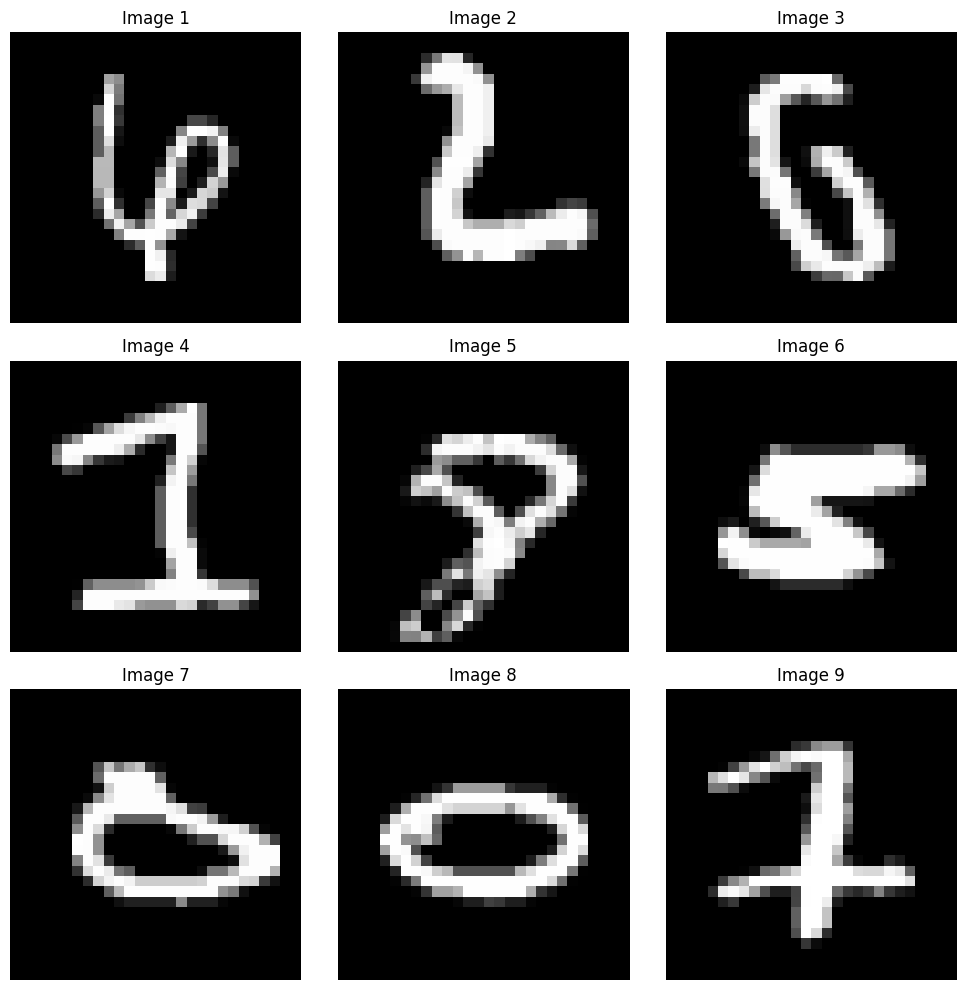

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.040280
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.065534
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.017885
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.031252
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.066634
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.100782
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.071058
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.042003
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.008167
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.102692

Test set: Average loss: 0.0001, Accuracy: 9830/10000 (98%)

Plotting top 9 confused images:


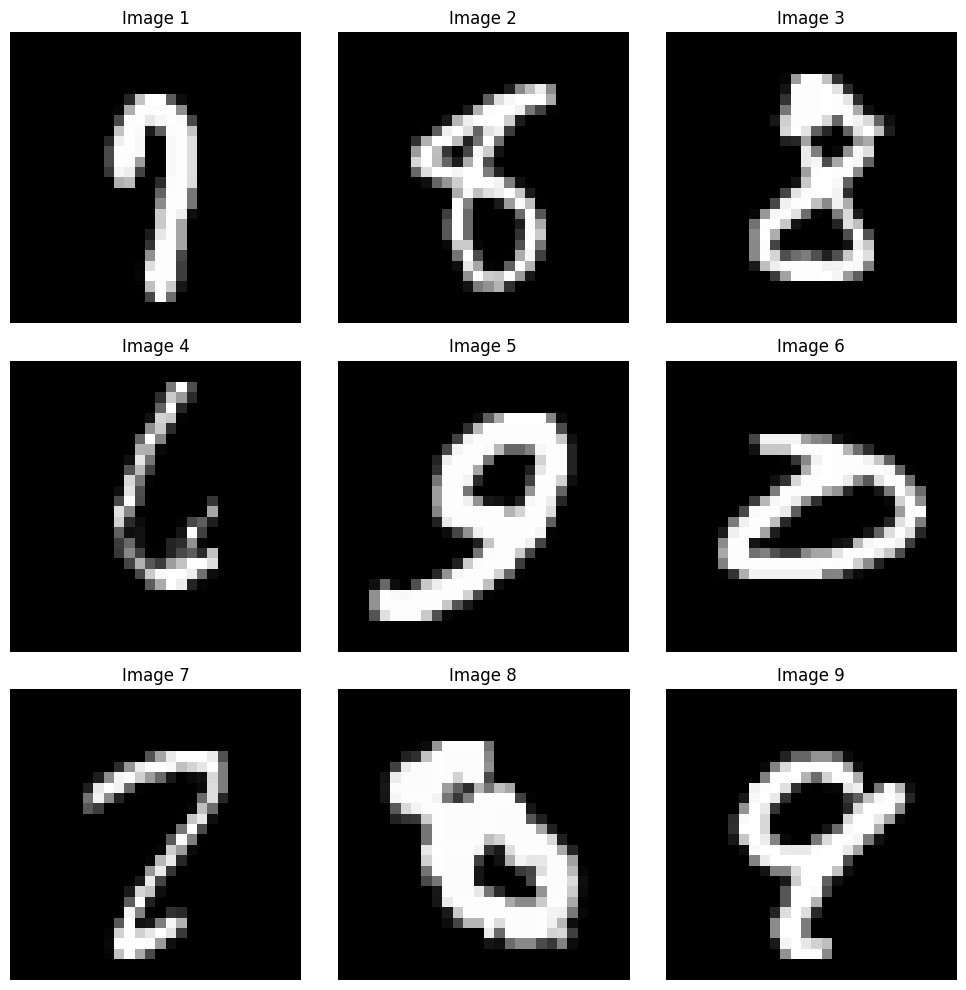

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.014794
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.025936
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.080930
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.039677
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.019256
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.120740
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.009786
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.012420
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.038544
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.018876

Test set: Average loss: 0.0001, Accuracy: 9861/10000 (99%)

Plotting top 9 confused images:


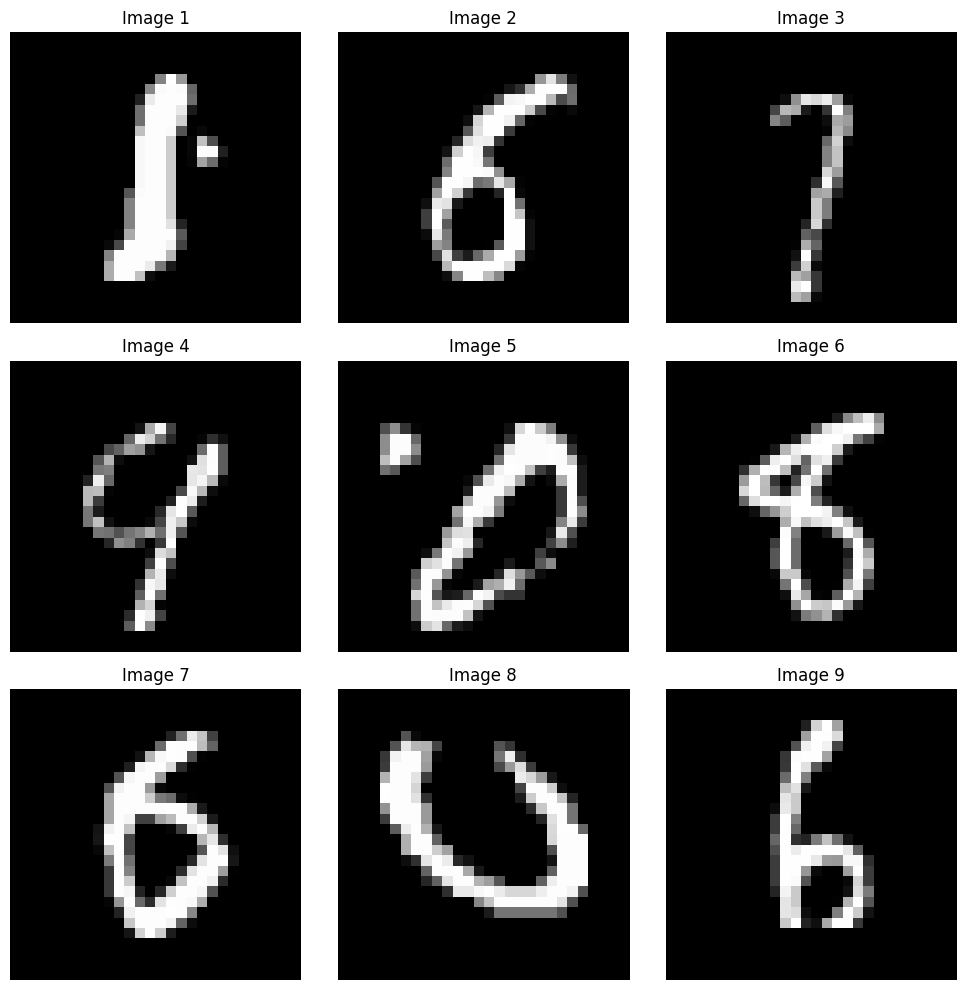

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.004563
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.021762
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.023616
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.043525
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.013819
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.057763
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.101595
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.019534
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.007155
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.029103

Test set: Average loss: 0.0001, Accuracy: 9858/10000 (99%)

Plotting top 9 confused images:


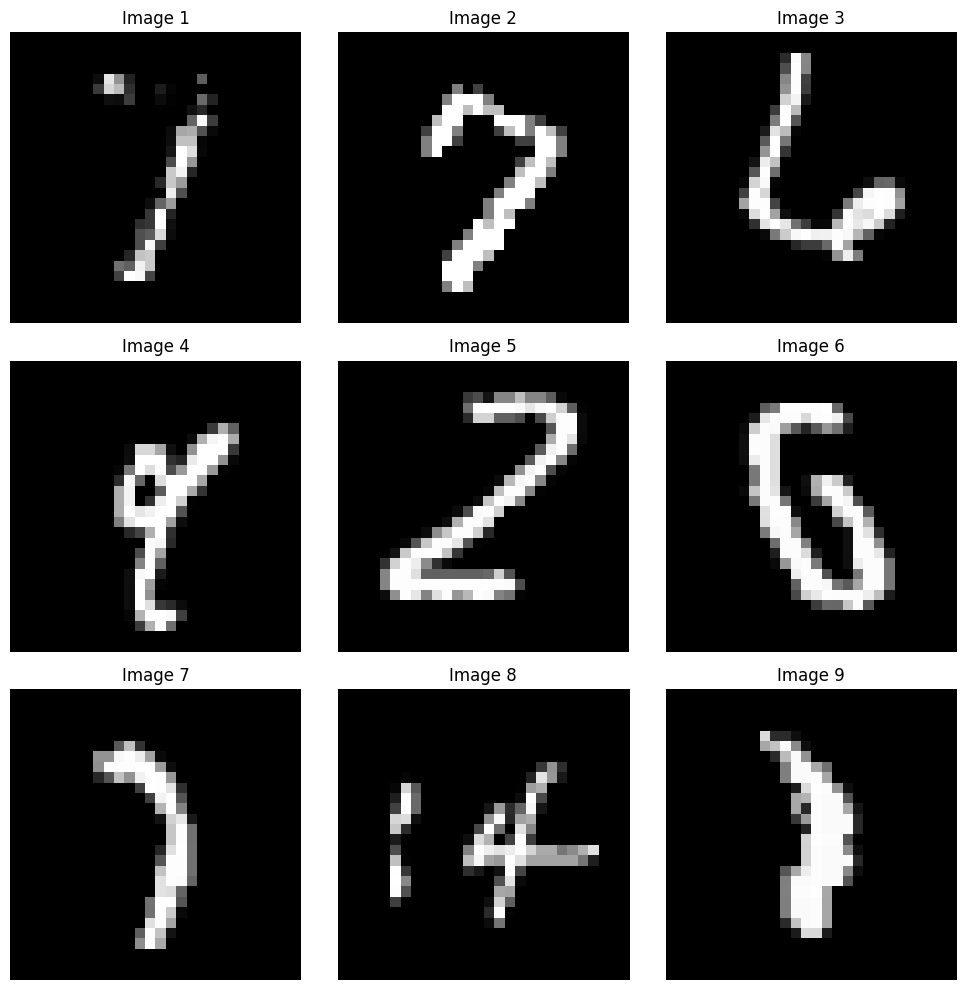

[I 2024-03-16 11:36:09,245] Trial 5 finished with value: 98.58 and parameters: {'lr': 0.006257452848151191, 'momentum': 0.9}. Best is trial 5 with value: 98.58.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.286259
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.295097
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.296150
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.279903
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.288369
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.296822
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.282932
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.282723
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.281962

Test set: Average loss: 0.0046, Accuracy: 2578/10000 (26%)

Plotting top 9 confused images:


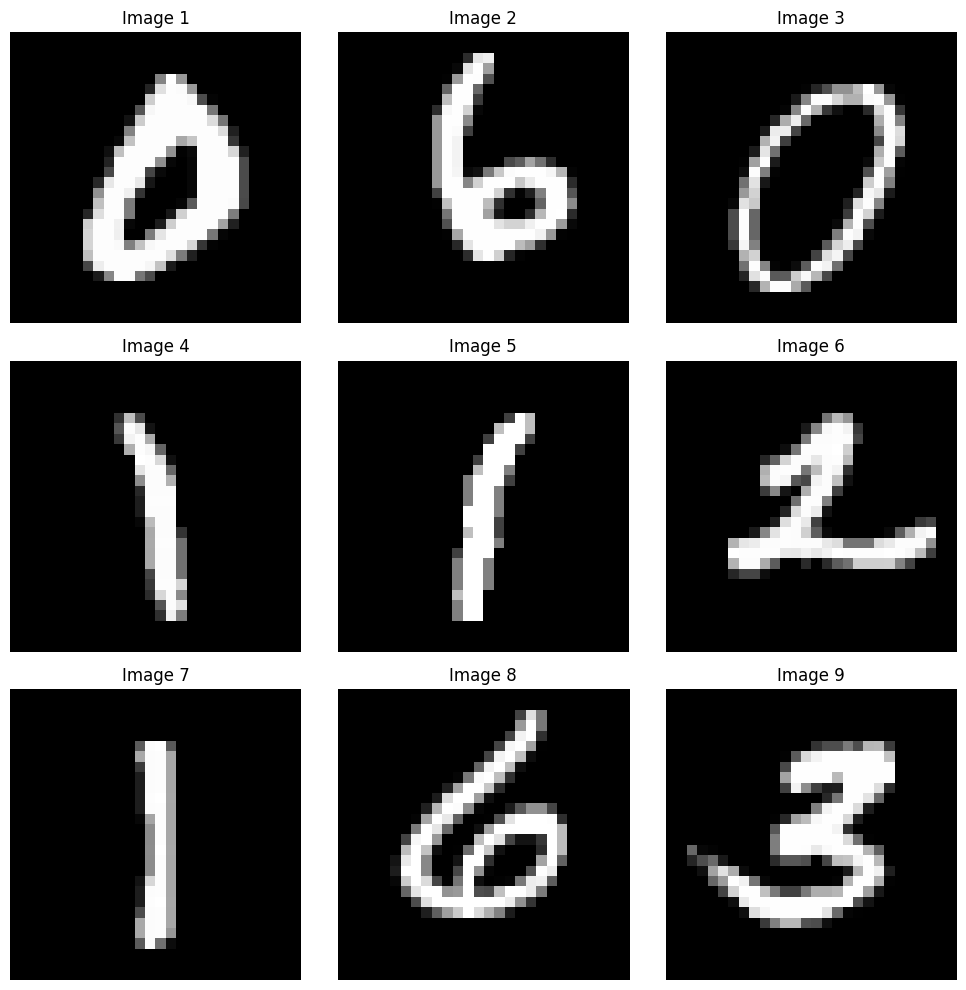

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.270772
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.281110
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.269940
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.290543
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.262020
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.268122
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.272291
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.271676
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.250623
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.264824

Test set: Average loss: 0.0045, Accuracy: 4335/10000 (43%)

Plotting top 9 confused images:


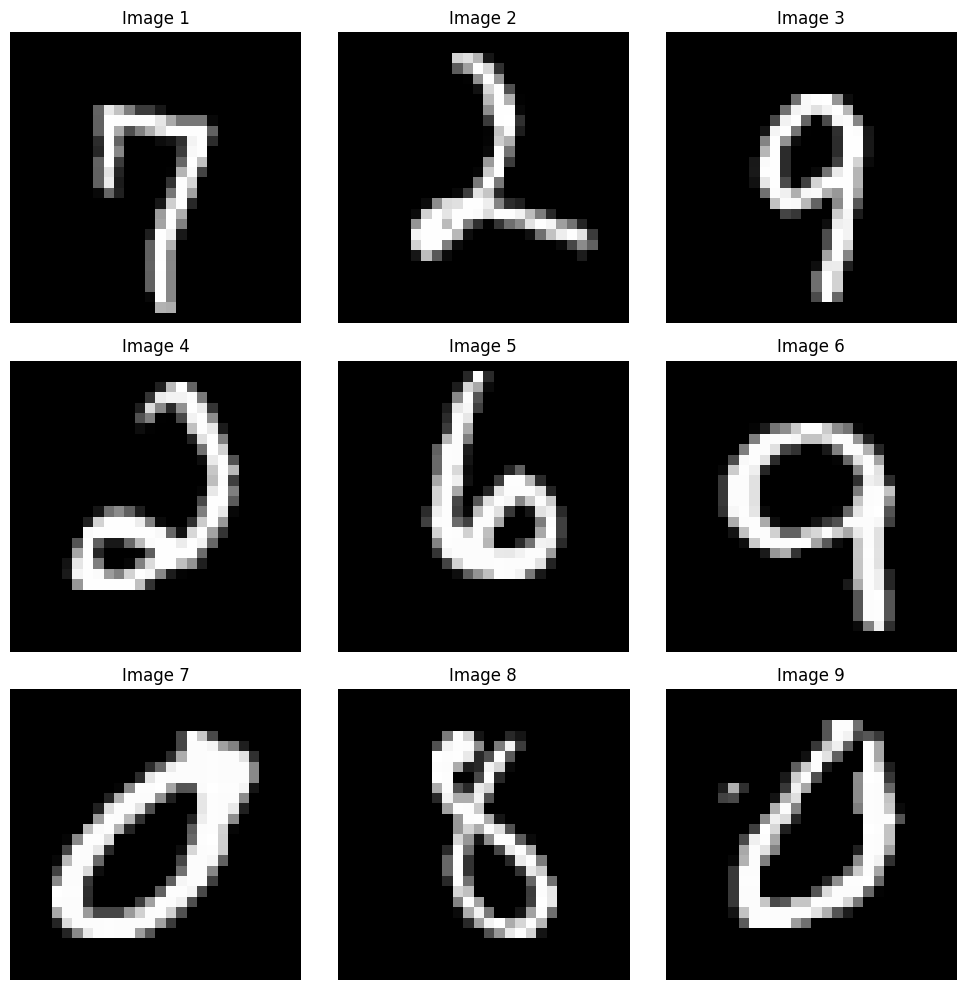

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.277047
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.267712
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.288209
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.247637
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.254177
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.260214
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.259318
Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.241874
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.230012
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.234627

Test set: Average loss: 0.0045, Accuracy: 5401/10000 (54%)

Plotting top 9 confused images:


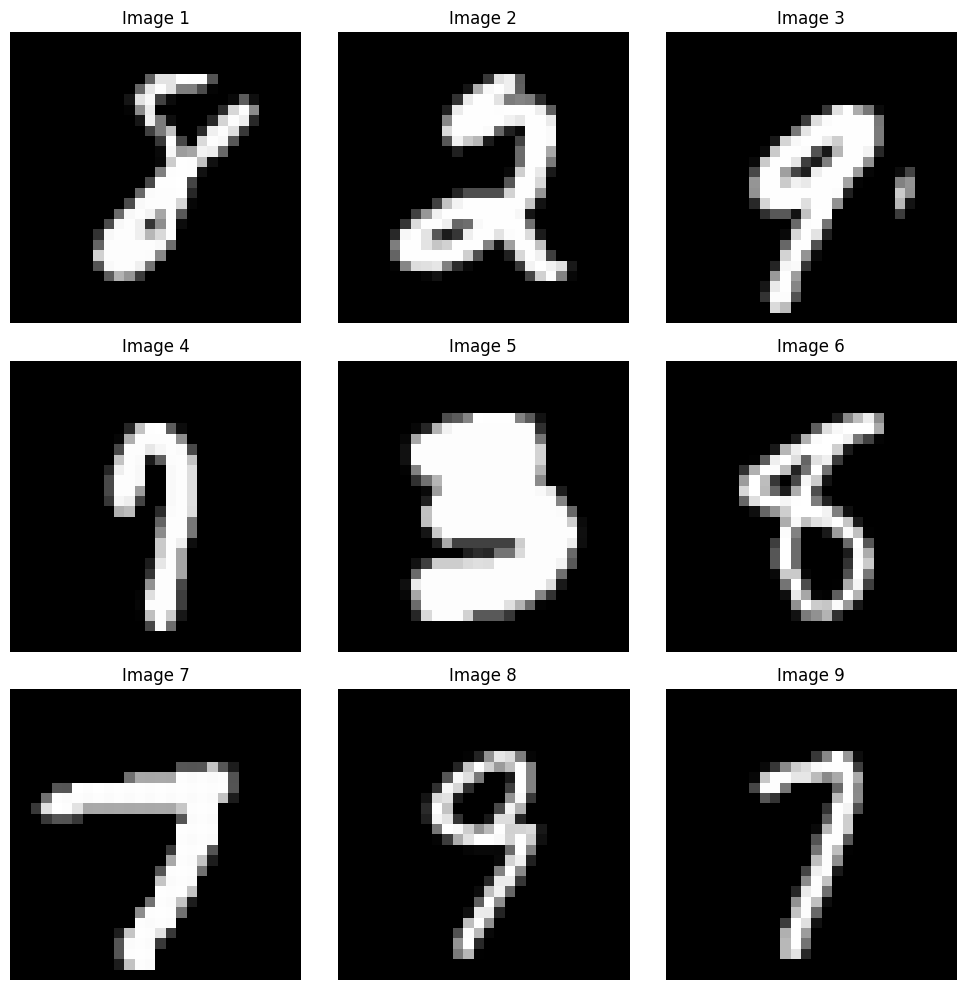

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.268795
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.244686
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.248503
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.223203
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.214497
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.218493
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.225894
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.213927
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.222814
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.217280

Test set: Average loss: 0.0044, Accuracy: 6030/10000 (60%)

Plotting top 9 confused images:


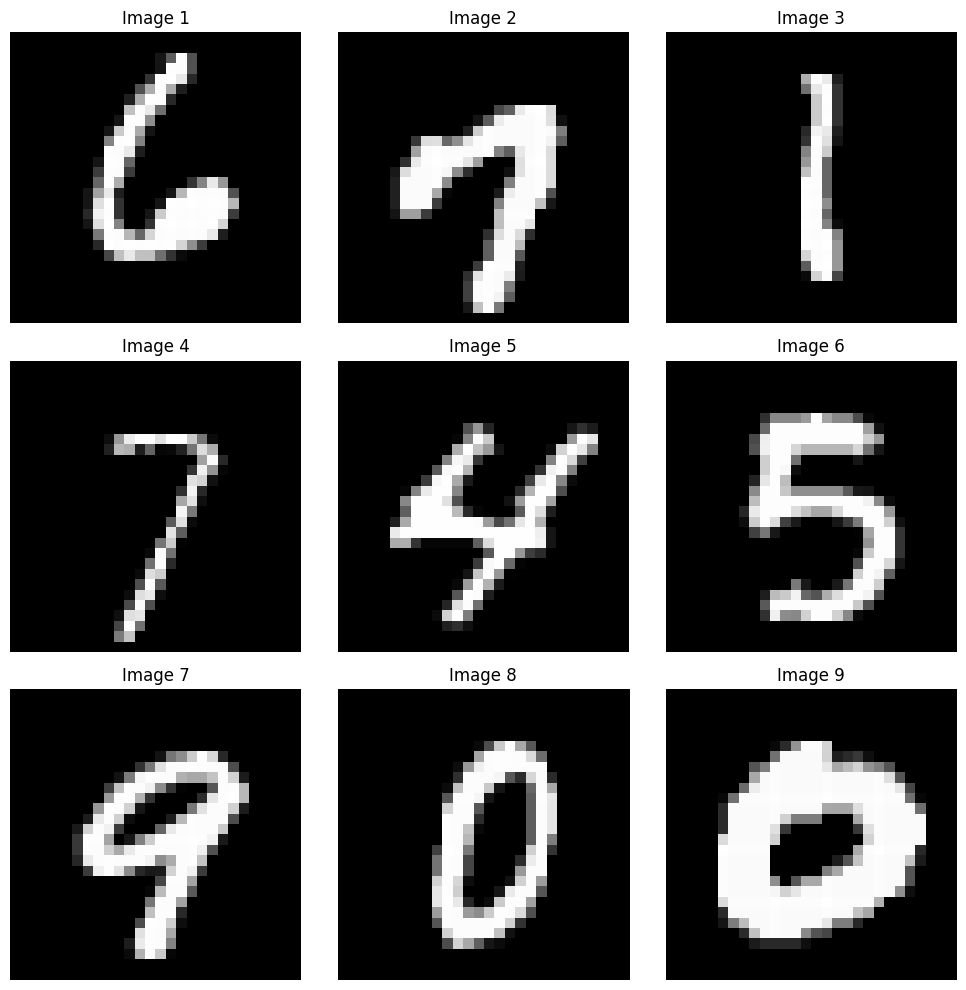

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.217185
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.185478
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.213737
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.184742
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.219802
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.214116
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.171549
Train Epoch: 5 [44800/60000 (75%)]	Loss: 2.175726
Train Epoch: 5 [51200/60000 (85%)]	Loss: 2.189315
Train Epoch: 5 [57600/60000 (96%)]	Loss: 2.168573

Test set: Average loss: 0.0043, Accuracy: 6449/10000 (64%)

Plotting top 9 confused images:


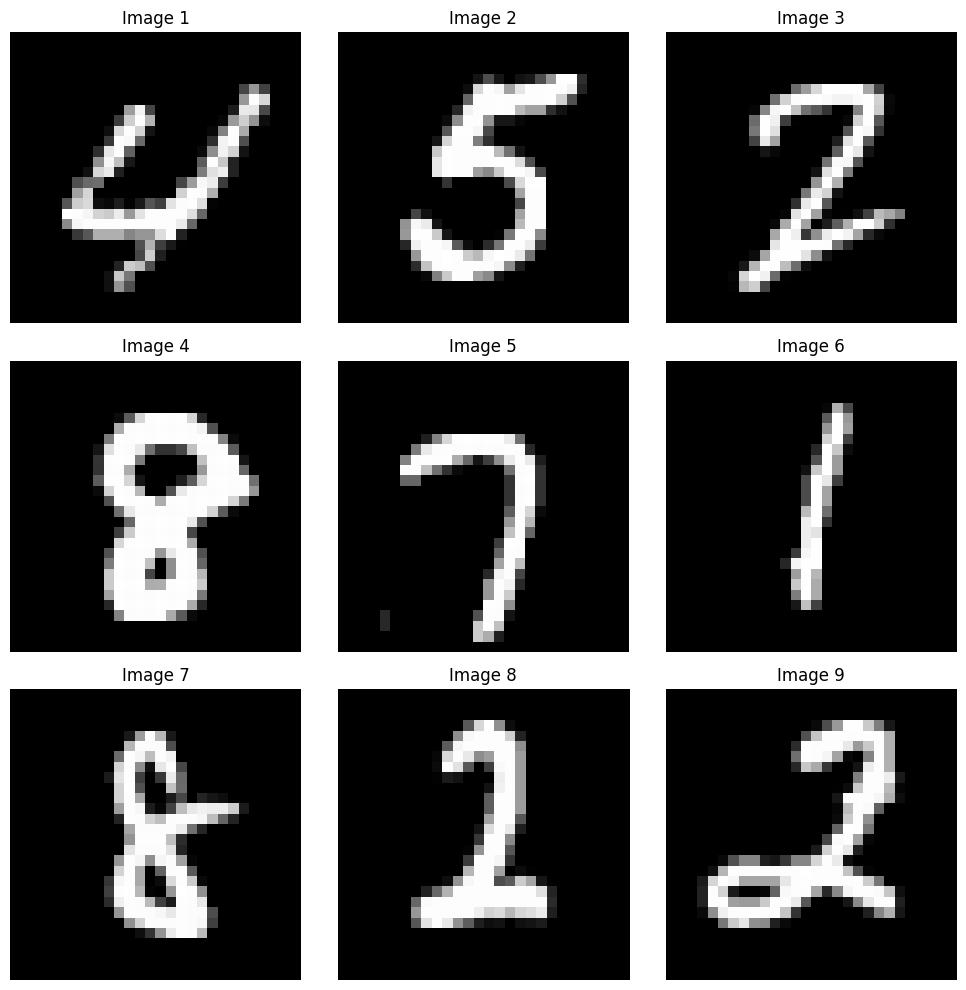

[I 2024-03-16 11:37:39,409] Trial 6 finished with value: 64.49000000000001 and parameters: {'lr': 5.84587990113273e-05, 'momentum': 0.6000000000000001}. Best is trial 5 with value: 98.58.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.217568
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.766309
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.332639
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.621101
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.285052
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.259356
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.303599
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.197033
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.474409

Test set: Average loss: 0.0003, Accuracy: 9564/10000 (96%)

Plotting top 9 confused images:


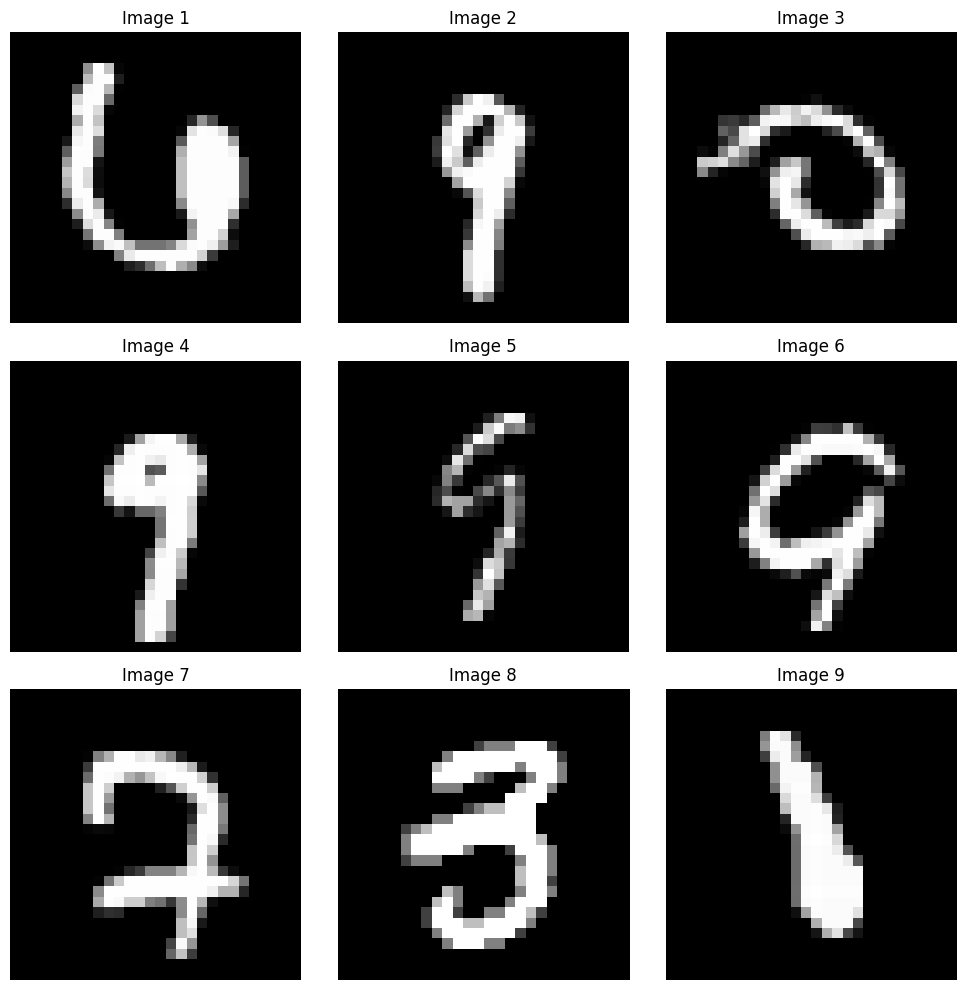

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.129410
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.175276
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.167357
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.186838
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.122732
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.149409
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.074903
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.082776
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.038121
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.087623

Test set: Average loss: 0.0002, Accuracy: 9754/10000 (98%)

Plotting top 9 confused images:


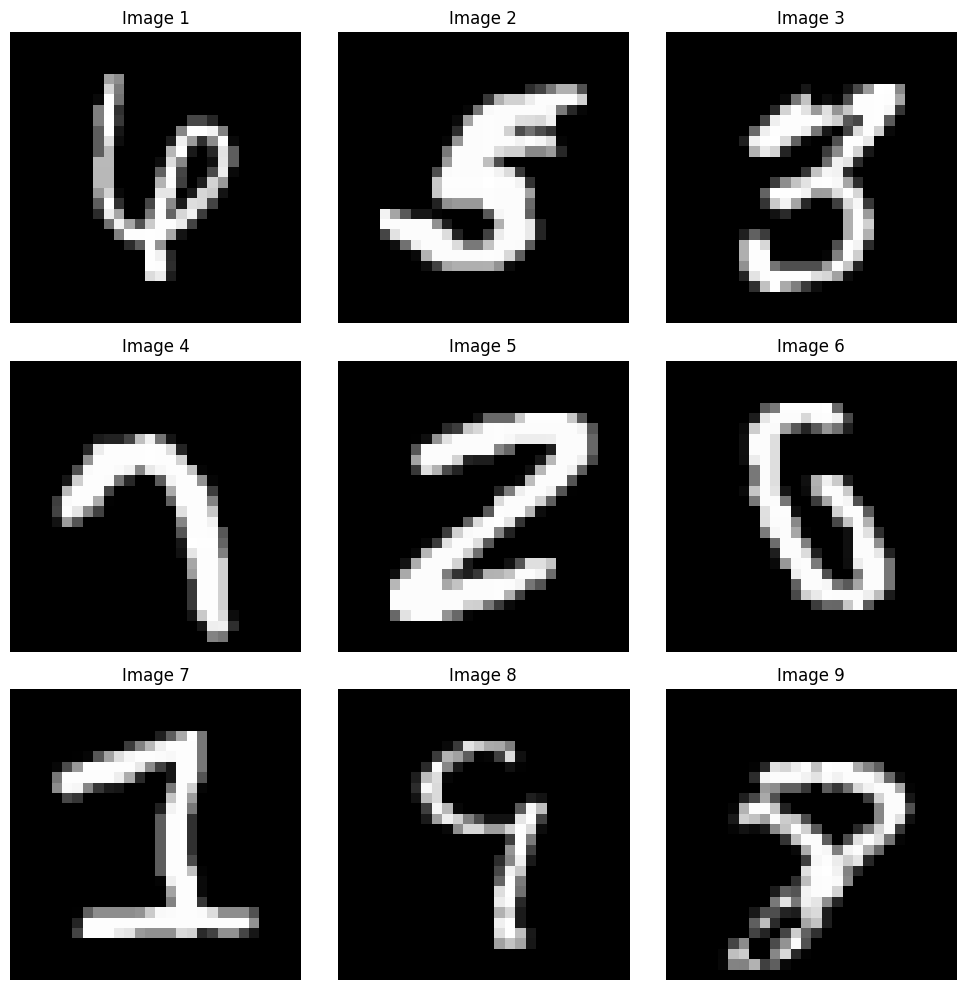

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.101007
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.086590
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.063295
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.112469
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.160513
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.156798
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.069778
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.123064
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.018337
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.163743

Test set: Average loss: 0.0001, Accuracy: 9768/10000 (98%)

Plotting top 9 confused images:


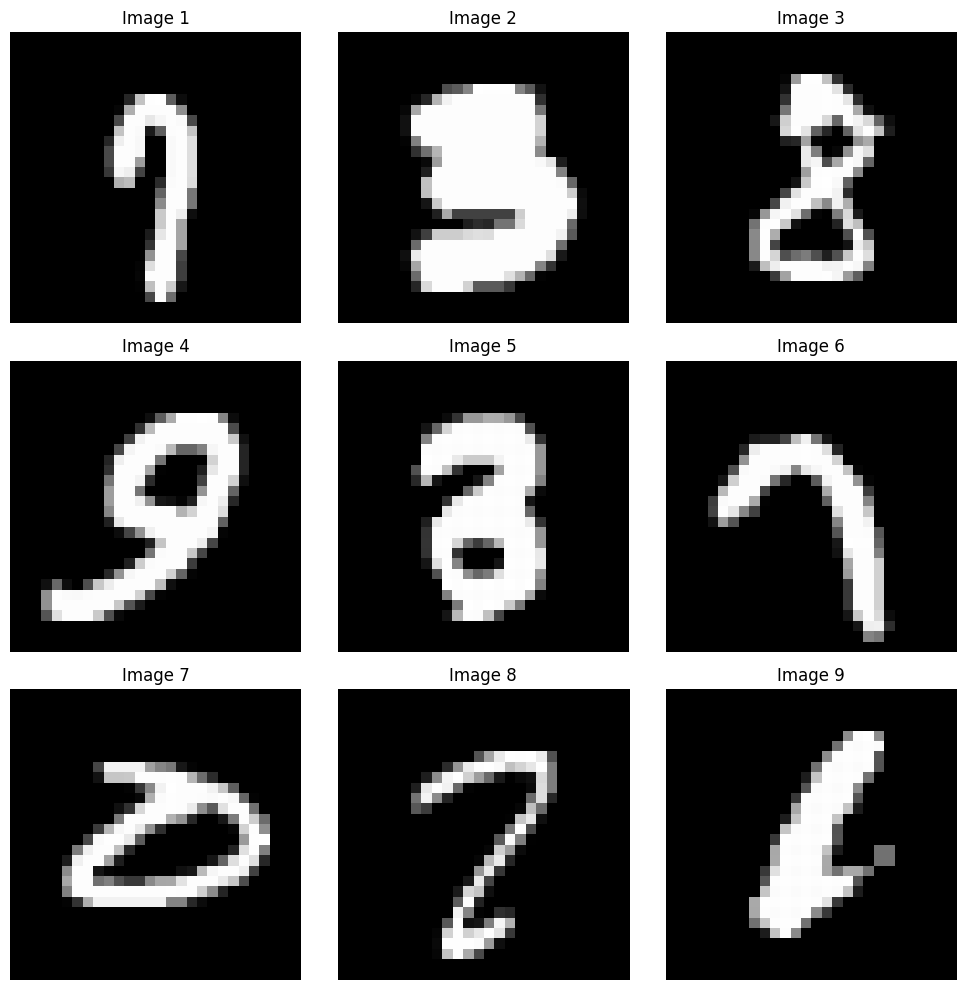

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.080477
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.054943
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.218747
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.039559
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.076792
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.341910
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.057453
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.030310
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.070613
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.017442

Test set: Average loss: 0.0001, Accuracy: 9807/10000 (98%)

Plotting top 9 confused images:


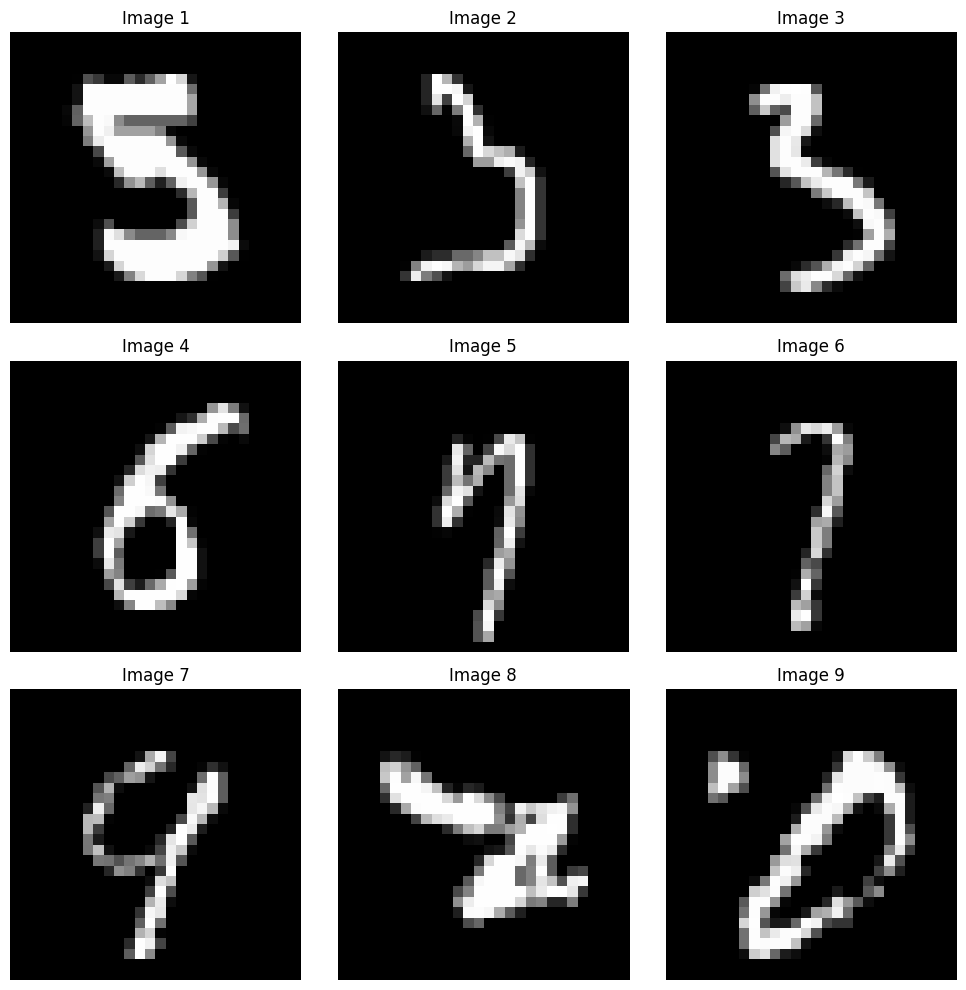

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.010375
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.046754
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.074809
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.026310
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.081885
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.093985
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.183778
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.049555
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.016738
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.074327

Test set: Average loss: 0.0001, Accuracy: 9799/10000 (98%)

Plotting top 9 confused images:


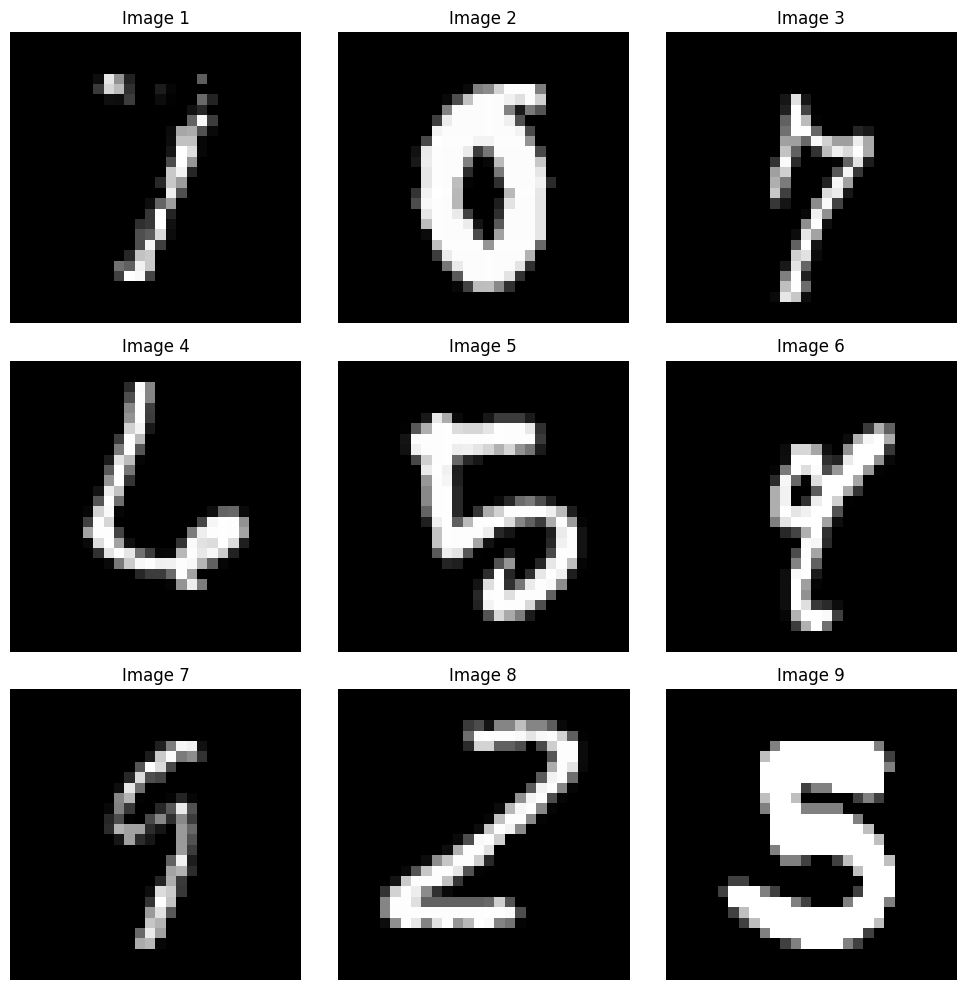

[I 2024-03-16 11:39:11,641] Trial 7 finished with value: 97.99 and parameters: {'lr': 0.0019578081182531973, 'momentum': 0.9}. Best is trial 5 with value: 98.58.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.258296
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.226184
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.139851
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.955551
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.572294
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.173208
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.885863
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.602356
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.829985

Test set: Average loss: 0.0010, Accuracy: 8644/10000 (86%)

Plotting top 9 confused images:


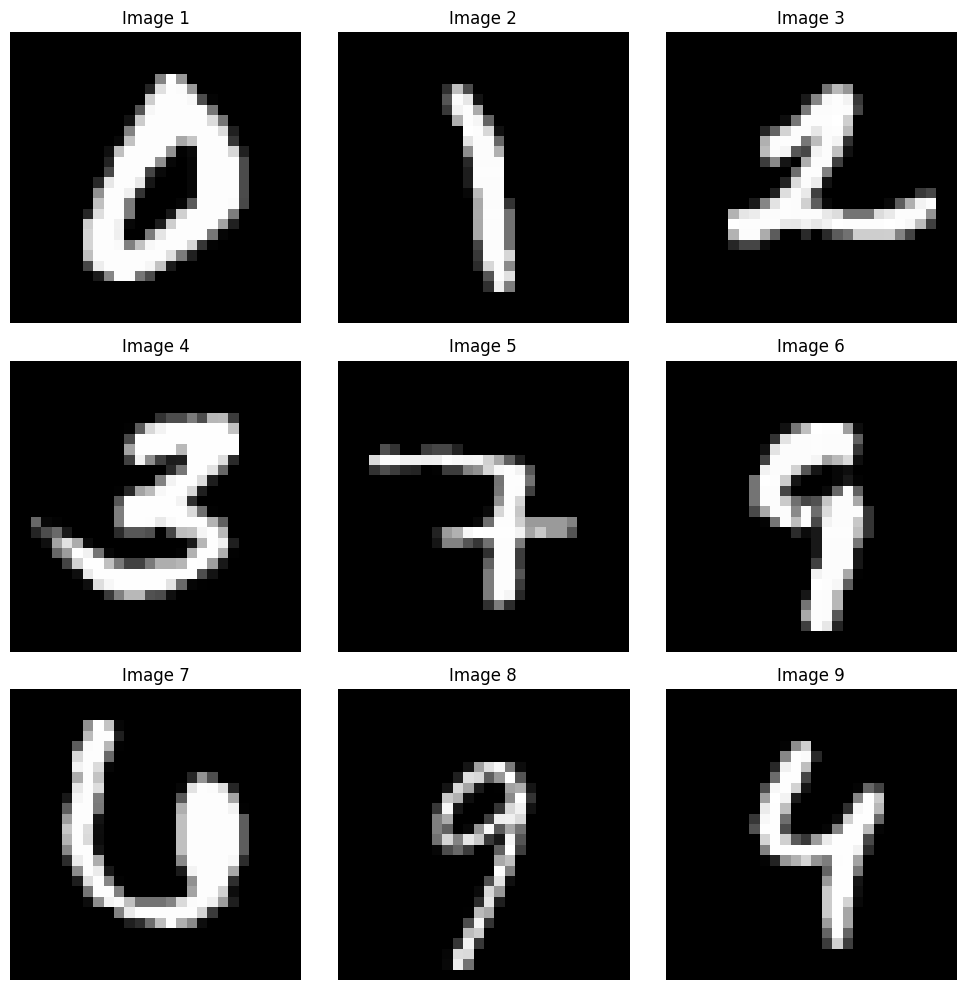

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.503010
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.424944
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.390206
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.452623
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.431247
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.479220
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.560279
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.370540
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.256566
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.243339

Test set: Average loss: 0.0006, Accuracy: 9094/10000 (91%)

Plotting top 9 confused images:


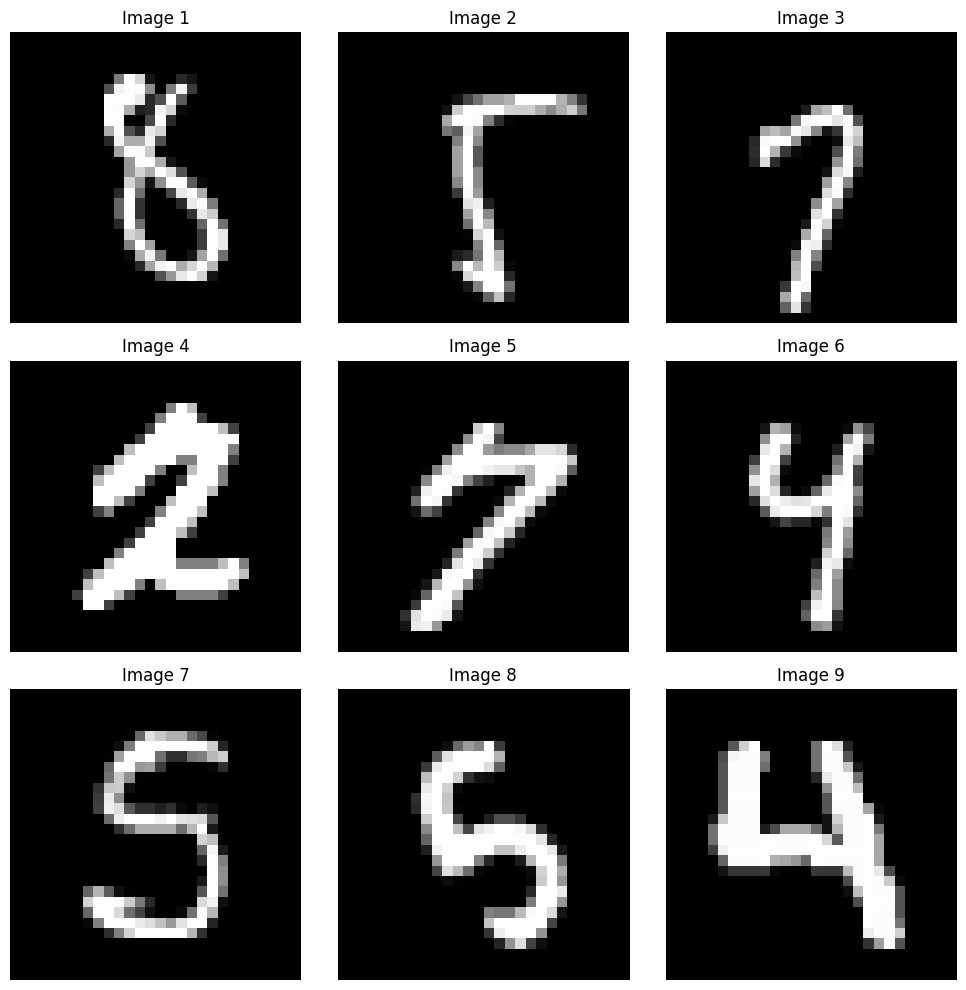

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.452627
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.277768
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.400241
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.403144
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.453966
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.298239
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.351011
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.185234
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.244080
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.584794

Test set: Average loss: 0.0005, Accuracy: 9290/10000 (93%)

Plotting top 9 confused images:


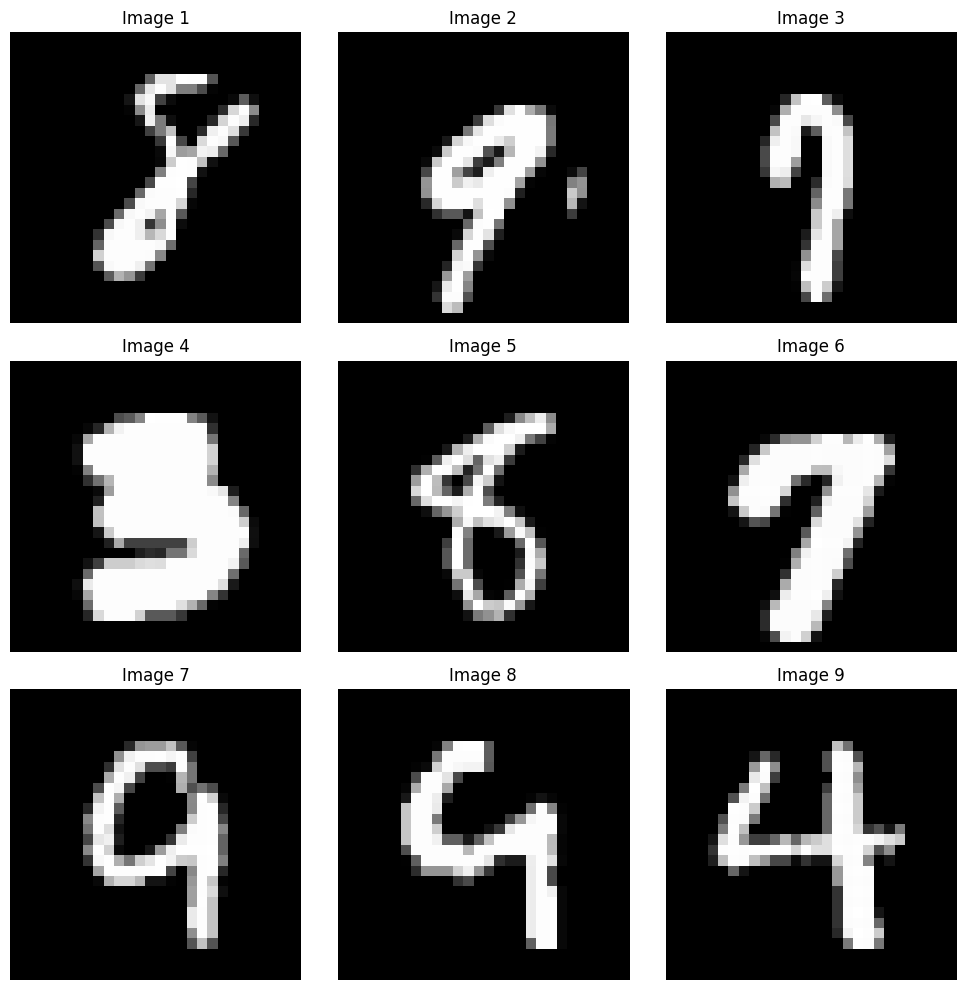

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.252287
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.328768
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.646630
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.247881
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.320130
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.673224
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.259239
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.160080
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.275372
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.206659

Test set: Average loss: 0.0004, Accuracy: 9404/10000 (94%)

Plotting top 9 confused images:


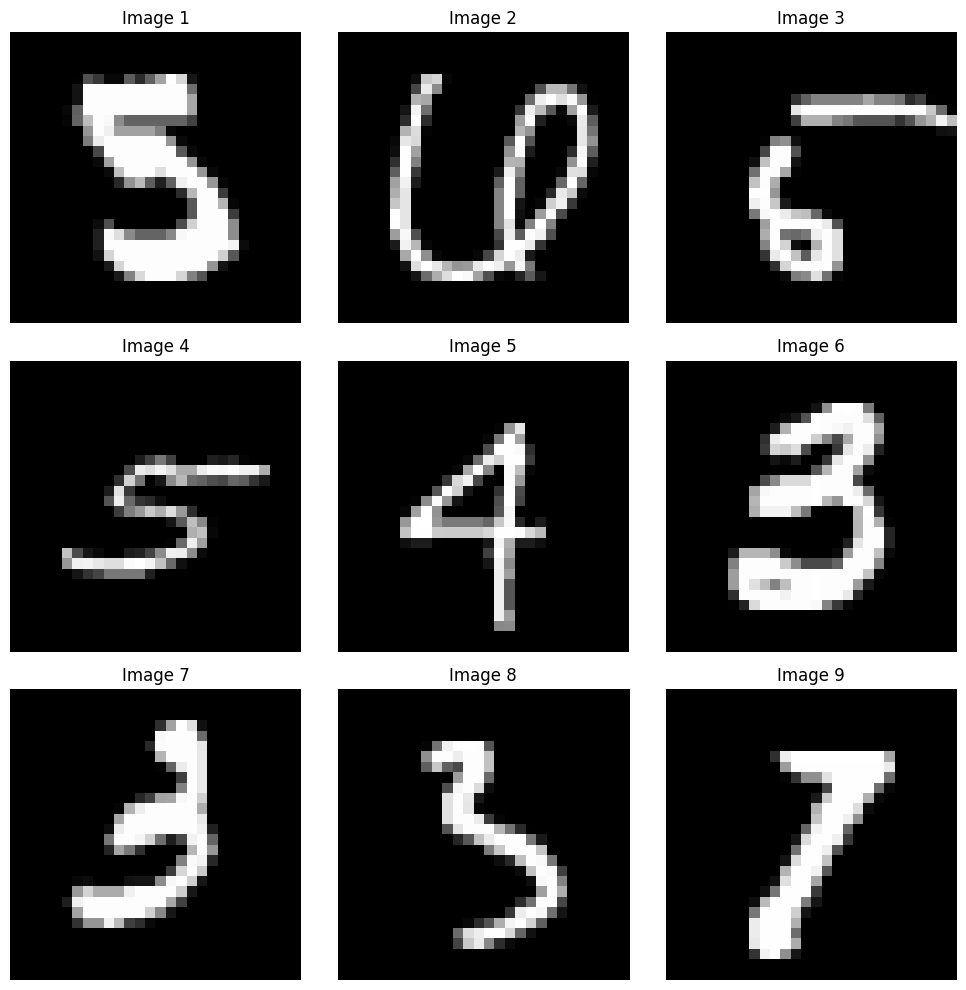

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.231862
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.223450
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.191852
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.274456
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.296476
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.315711
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.321353
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.178777
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.168370
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.360110

Test set: Average loss: 0.0004, Accuracy: 9402/10000 (94%)

Plotting top 9 confused images:


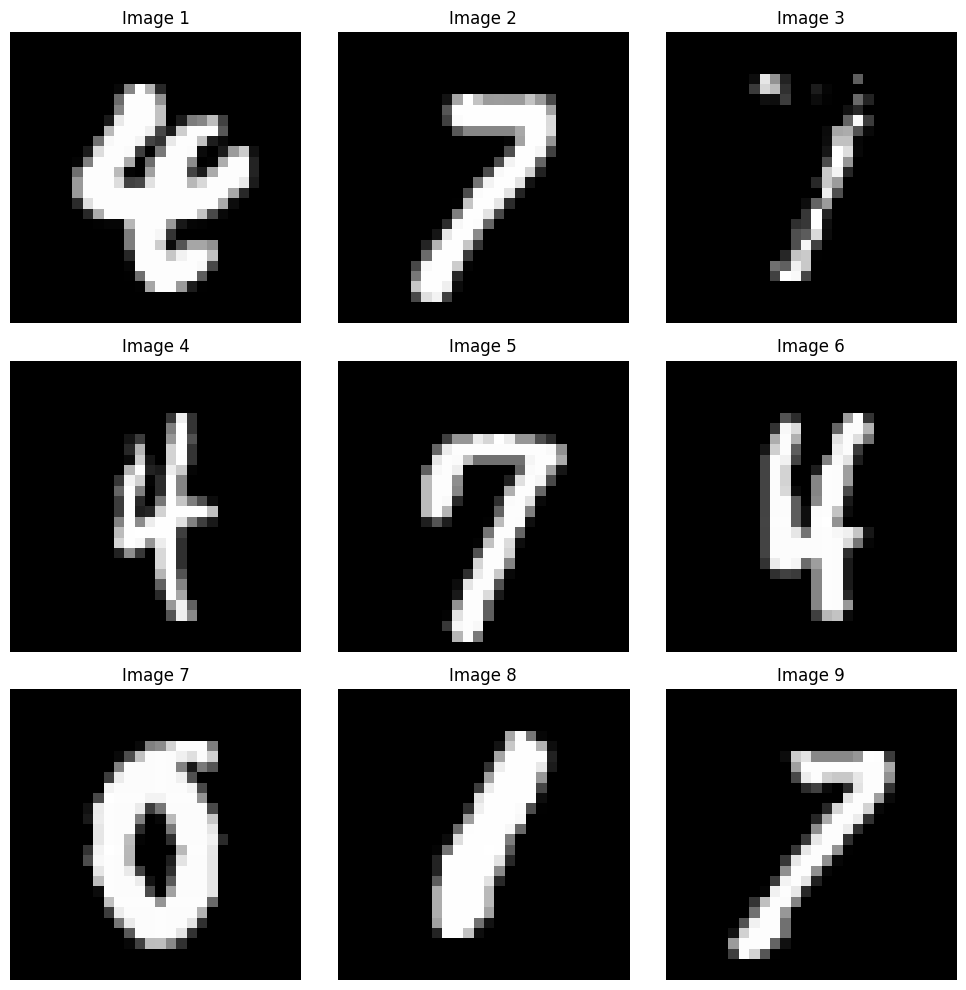

[I 2024-03-16 11:40:42,393] Trial 8 finished with value: 94.02000000000001 and parameters: {'lr': 0.0002784778493200942, 'momentum': 0.9}. Best is trial 5 with value: 98.58.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.283079
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.288287
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.285801
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.266776
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.269047
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.273565
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.254251
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.245867
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.243611

Test set: Average loss: 0.0045, Accuracy: 5517/10000 (55%)

Plotting top 9 confused images:


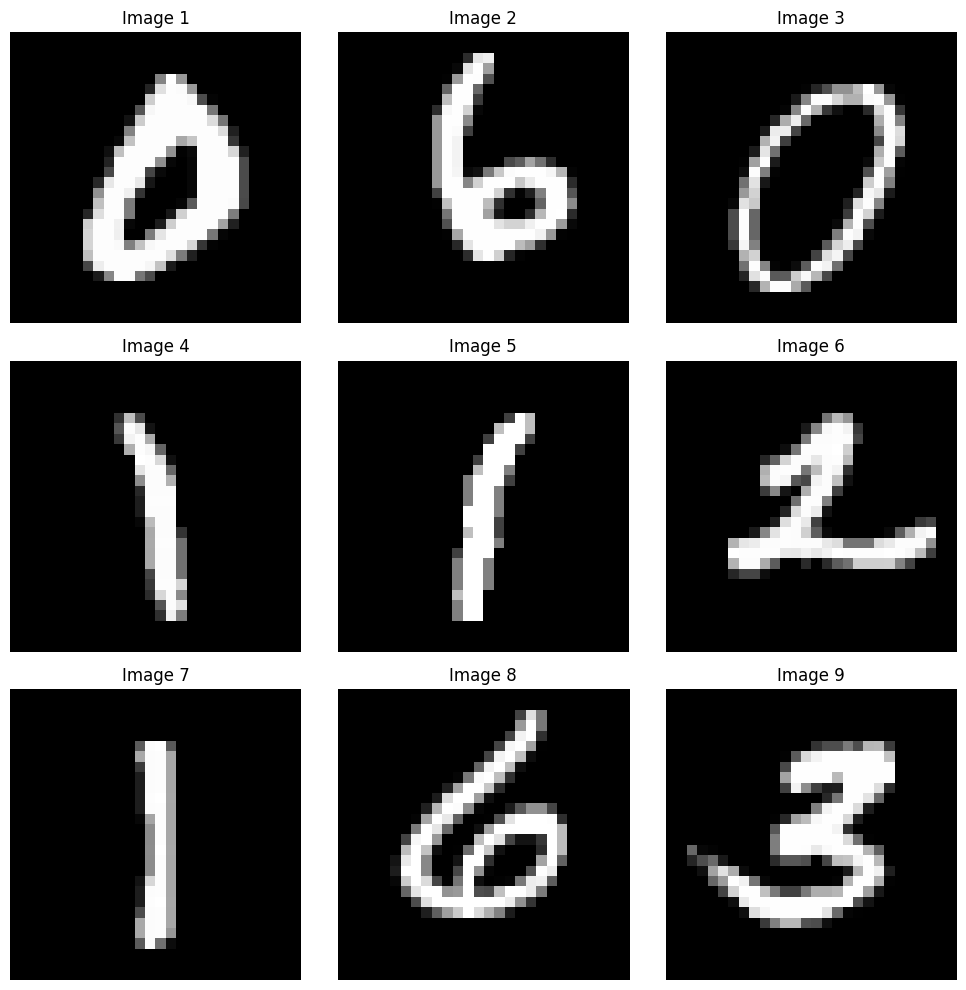

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.228236
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.233399
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.205997
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.224177
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.179113
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.168431
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.164432
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.144296
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.104345
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.085434

Test set: Average loss: 0.0041, Accuracy: 6878/10000 (69%)

Plotting top 9 confused images:


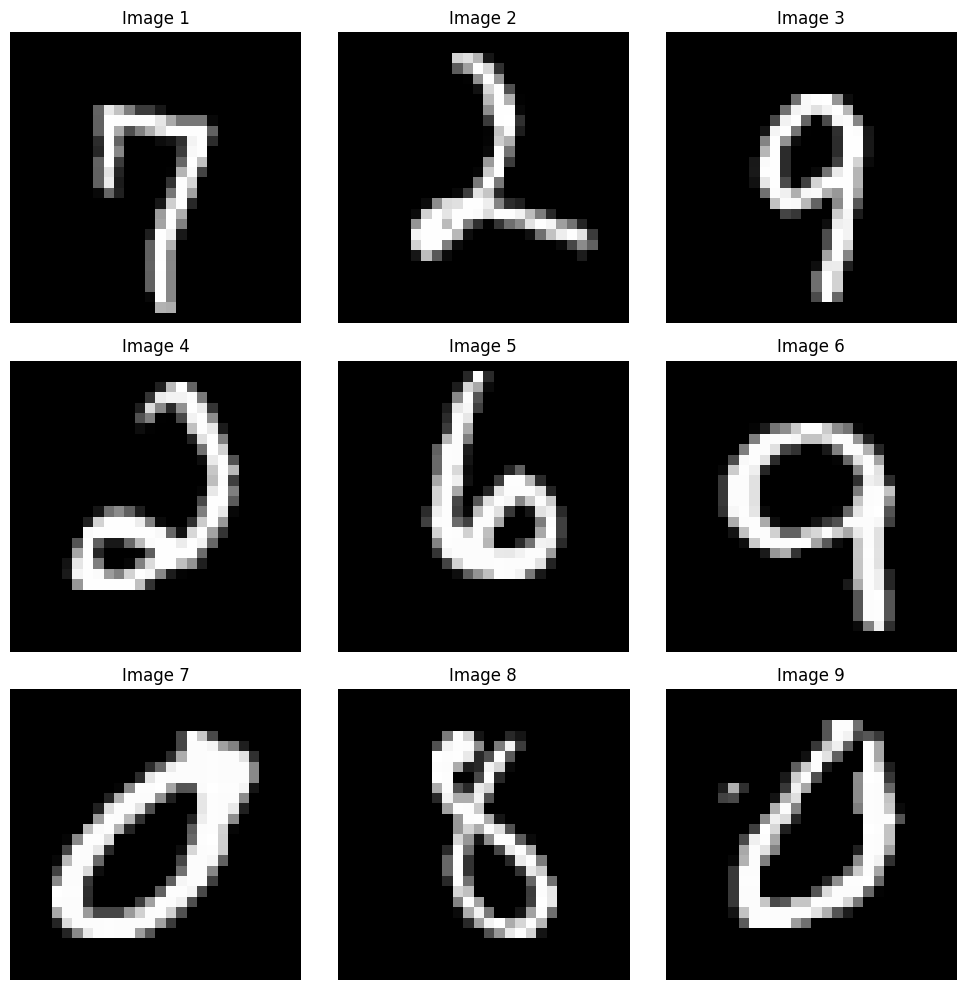

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.120634
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.040220
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.057190
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.972630
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.949421
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.911161
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.919984
Train Epoch: 3 [44800/60000 (75%)]	Loss: 1.734485
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.672597
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.638497

Test set: Average loss: 0.0031, Accuracy: 7608/10000 (76%)

Plotting top 9 confused images:


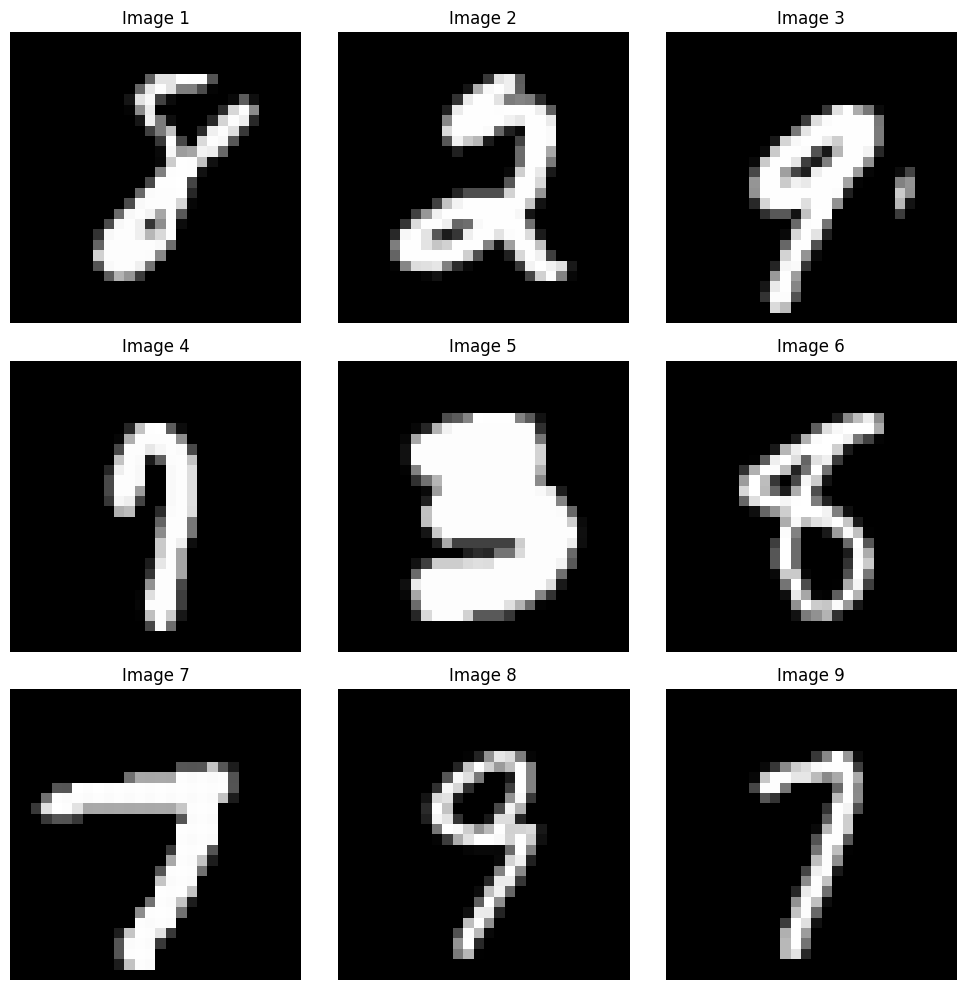

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.694611
Train Epoch: 4 [6400/60000 (11%)]	Loss: 1.496784
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.486199
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.332105
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.263010
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.361383
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.071272
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.947545
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.911621
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.982247

Test set: Average loss: 0.0017, Accuracy: 8141/10000 (81%)

Plotting top 9 confused images:


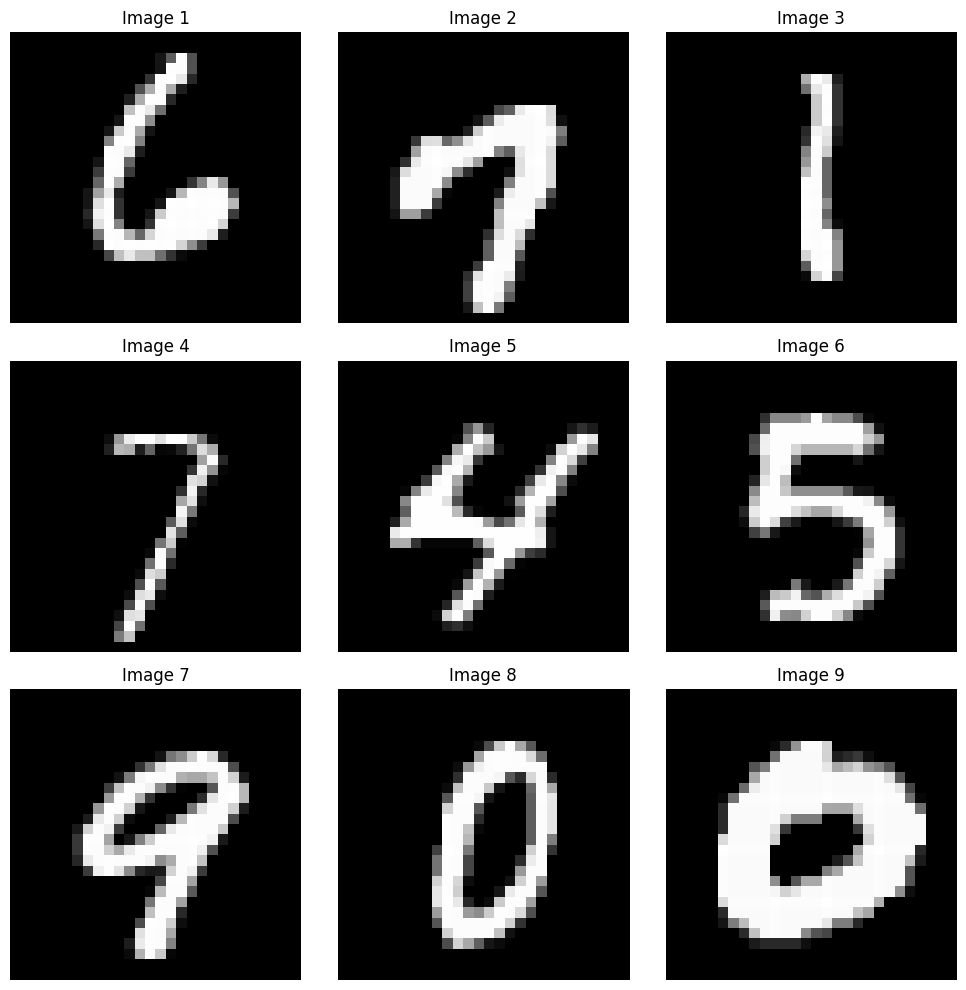

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.930010
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.783551
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.984343
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.803612
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.847956
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.863765
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.799266
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.674654
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.775026
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.676572

Test set: Average loss: 0.0011, Accuracy: 8505/10000 (85%)

Plotting top 9 confused images:


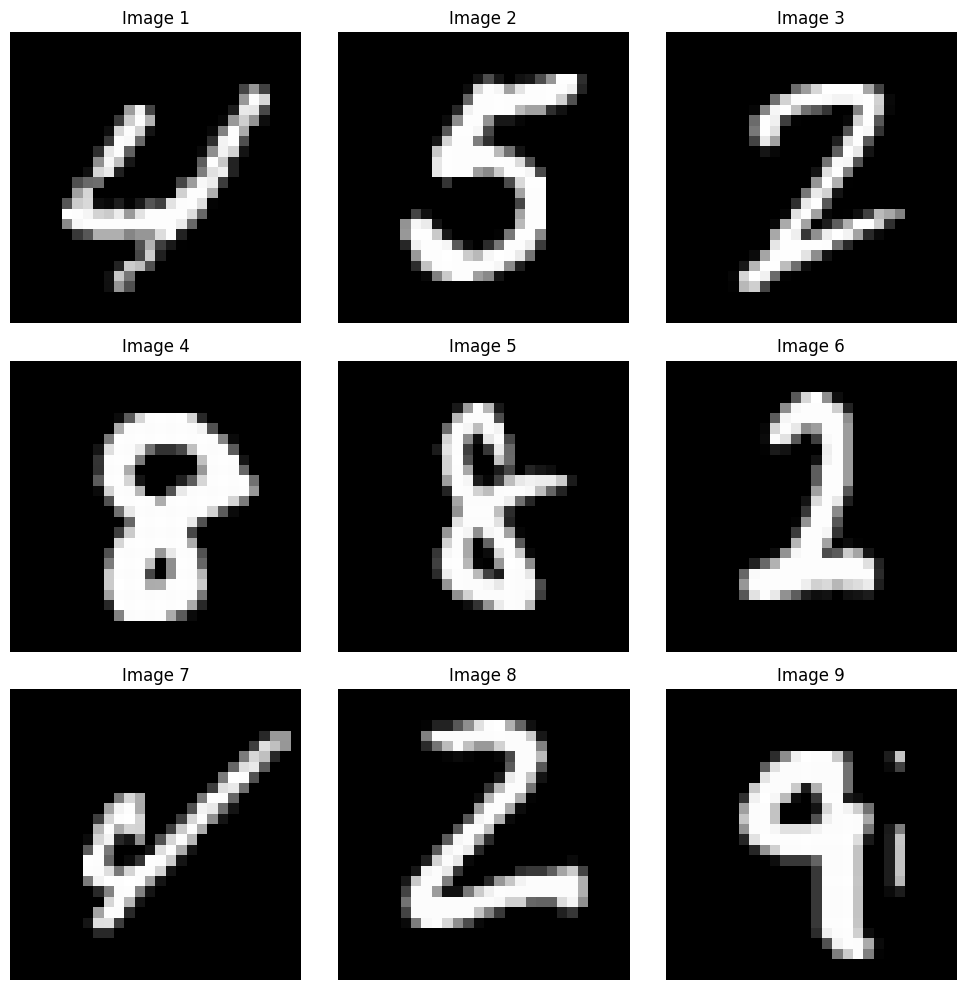

[I 2024-03-16 11:42:14,209] Trial 9 finished with value: 85.05 and parameters: {'lr': 9.33940002868796e-05, 'momentum': 0.8}. Best is trial 5 with value: 98.58.


In [24]:
storage = "sqlite:///db.sqlite3"
study = optuna.create_study(study_name="mnist_classification", direction='maximize', storage=storage)
study.optimize(objective, n_trials=10)

In [25]:
study.best_value

98.58

In [26]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_lr,params_momentum,state
0,0,94.48,2024-03-16 11:27:32.285370,2024-03-16 11:28:57.778687,0 days 00:01:25.493317,0.001006,0.6,COMPLETE
1,1,88.37,2024-03-16 11:28:57.790991,2024-03-16 11:30:23.200416,0 days 00:01:25.409425,0.000246,0.6,COMPLETE
2,2,45.78,2024-03-16 11:30:23.211150,2024-03-16 11:31:49.265481,0 days 00:01:26.054331,0.000019,0.7,COMPLETE
3,3,38.05,2024-03-16 11:31:49.275647,2024-03-16 11:33:14.856919,0 days 00:01:25.581272,0.000020,0.6,COMPLETE
4,4,77.03,2024-03-16 11:33:14.866291,2024-03-16 11:34:41.668046,0 days 00:01:26.801755,0.000085,0.7,COMPLETE
5,5,98.58,2024-03-16 11:34:41.677402,2024-03-16 11:36:09.239765,0 days 00:01:27.562363,0.006257,0.9,COMPLETE
6,6,64.49,2024-03-16 11:36:09.249344,2024-03-16 11:37:39.404071,0 days 00:01:30.154727,0.000058,0.6,COMPLETE
7,7,97.99,2024-03-16 11:37:39.413743,2024-03-16 11:39:11.636109,0 days 00:01:32.222366,0.001958,0.9,COMPLETE
8,8,94.02,2024-03-16 11:39:11.645697,2024-03-16 11:40:42.386706,0 days 00:01:30.741009,0.000278,0.9,COMPLETE
9,9,85.05,2024-03-16 11:40:42.397553,2024-03-16 11:42:14.204341,0 days 00:01:31.806788,0.000093,0.8,COMPLETE


## Run the dashboard with the below command
__optuna-dashboard sqlite:///db.sqlite3__

## Human in the loop optimisation with Optuna

In [40]:
from optuna_dashboard import save_note, register_objective_form_widgets, ChoiceWidget
import textwrap
import cv2
import time
from optuna.trial import TrialState

from optuna.artifacts import FileSystemArtifactStore
from optuna.artifacts import upload_artifact
from optuna_dashboard.artifact import get_artifact_path

from PIL import Image

In [41]:
def train_model(model, train_loader, optimizer, criterion, log_interval, epoch, device):

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))

        loss = criterion(output, target.to(device))
        loss.backward()

        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        
def validate_model(model, test_loader, criterion, device, img_path, epoch, num_epochs, entropy_threshold=0.5):

    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    #get the confused images
    confused_images = []
    actual_labels = []
    predicted_labels = []

    with torch.no_grad():
        for _, (data, target) in enumerate(test_loader):
            output = model(data).to(device)
            total_loss += criterion(output, target.to(device)).item()
            
            #model prediction
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Calculate entropy
            probabilities = torch.softmax(output, dim=1)
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-8), dim=1)
            
            # Find indices of confused images
            confused_mask = entropy > entropy_threshold
            confused_images.extend(data[confused_mask].cpu().numpy())

            # Store actual and predicted labels of confused images
            actual_labels.extend(target[confused_mask].cpu().numpy())
            predicted_labels.extend(predicted[confused_mask].cpu().numpy())

    total_loss /= len(test_loader.dataset)
    test_accuracy = 100. * (correct / len(test_loader.dataset))
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        total_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Plot the top 9 confused images
    if confused_images and epoch==num_epochs:
        plot_top_confused_images(confused_images, actual_labels, predicted_labels, img_path)
        

    return test_accuracy

def plot_top_confused_images(confused_images, actual_labels, predicted_labels, output_path):
    n_confused_images = min(len(confused_images), 6)
    print(f"Plotting top {n_confused_images} confused images:")

    fig, axes = plt.subplots(2, 3, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flat):
        if i < n_confused_images:
            ax.imshow(confused_images[i].squeeze(), cmap='gray')
            ax.set_title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}")
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    plt.show()

In [42]:
def objective(study: optuna.Study, artifact_store: FileSystemArtifactStore):

    #ask the trial number
    trial = study.ask()

    cfg = {
        'device': "cuda" if torch.cuda.is_available() else "cpu",
        'log_interval': 100,
        'seed': 0,
        'save_model': False,
        'n_epochs': 5,
        'train_batch_size': 64,
        'test_batch_size': 512,
        'lr': trial.suggest_float("lr", 1e-5, 1e-2, log=True),
        'momentum': trial.suggest_float("momentum", 0.4, 0.9, step=0.1),
        'criterion': nn.CrossEntropyLoss()
    }

    torch.manual_seed(cfg['seed'])
    train_loader, test_loader = get_mnist_loaders(cfg['train_batch_size'], cfg['test_batch_size'])
    model = SimpleCNN().to(cfg['device'])
    optimizer = optim.SGD(model.parameters(), lr=cfg['lr'], momentum=cfg['momentum'])
    for epoch in range(1, cfg['n_epochs']+1):
        train_model(model, train_loader, optimizer, cfg['criterion'], cfg['log_interval'], epoch, cfg['device']) #training the model

        #get the image path
        img_path = f"tmp/confused_lot-{trial.number}.png"
        test_accuracy = validate_model(model, test_loader, cfg['criterion'], cfg['device'], img_path, epoch, cfg['n_epochs'])

        #saving the artifacts to the artifacts directory
        if epoch == cfg['n_epochs']:
            artifacts_id = upload_artifact(trial, img_path, artifact_store)
            artifact_path = get_artifact_path(trial, artifacts_id)

    if cfg['save_model']:
        torch.save(model.state_dict(), "mnist_cnn.pt")

    # 4. Save Note
    note = textwrap.dedent(
        f"""\
    ## Trial {trial.number}

    ![generated-image]({artifact_path})

    Test Accuracy of the model: {test_accuracy:.2f}
    """
    )
    save_note(trial, note)

    return test_accuracy


In [43]:
def start_optimization(artifact_store: FileSystemArtifactStore):
    # 1. Create Study
    storage = "sqlite:///db.sqlite3"
    study = optuna.create_study(study_name="HITL_with_optuna_for_digit_classification", 
                                direction='maximize', 
                                storage=storage,
                                load_if_exists=True)

    # 2. Set an objective name
    study.set_metric_names(["Are you satisfied with the model's validation accuracy?"])

    # 3. Register ChoiceWidget
    register_objective_form_widgets(
        study,
        widgets=[
            ChoiceWidget(
                choices=["Yes 👍", "Somewhat 👌", "No 👎"],
                values=[1, 0, -1],
                description="Please input your score!",
            ),
        ],
    )

    # 4. Start Human-in-the-loop Optimization
    n_batch = 2
    while True:
        running_trials = study.get_trials(deepcopy=False, states=(TrialState.RUNNING,))
        if len(running_trials) >= n_batch:
            time.sleep(1)  # Avoid busy-loop
            continue
        objective(study, artifact_store)

In [44]:
def main():
    # tmp_path = os.path.join(os.path.dirname(__file__), "tmp")
    # Get the absolute path to the current notebook file
    notebook_dir = os.getcwd()

    # Create the absolute path to the "tmp" folder
    tmp_path = os.path.join(notebook_dir, "tmp")

    # 1. Create Artifact Store
    # artifact_path = os.path.join(os.path.dirname(__file__), "artifact")
    artifact_path = os.path.join(notebook_dir, "artifact")
    artifact_store = FileSystemArtifactStore(artifact_path)

    print(f"paths : {tmp_path}, {artifact_path}")

    if not os.path.exists(artifact_path):
        os.mkdir(artifact_path)

    if not os.path.exists(tmp_path):
        os.mkdir(tmp_path)

    # 2. Run optimize loop
    start_optimization(artifact_store)


if __name__ == "__main__":
    main()

[I 2024-03-16 13:06:00,827] A new study created in RDB with name: HITL_with_optuna_for_digit_classification


paths : /Users/mayankkhulbe/Mayank_python/personal_projects/Optuna/experiments/tmp, /Users/mayankkhulbe/Mayank_python/personal_projects/Optuna/experiments/artifact
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.268867
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.256296
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.224239
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.162342
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.078286
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.976847
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.764444
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.426357
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.301263

Test set: Average loss: 0.0019, Accuracy: 8036/10000 (80%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.016811
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.889185
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.688696
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.674391
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.630370
Train Epoch: 2 [32000/60000 (53%)]	Lo

KeyboardInterrupt: 

NameError: name 'study' is not defined